In [352]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import math
import pandas as pd
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly
import emcee
import corner
from scipy.optimize import minimize
from IPython.display import display, Math
import matplotlib as mpl
from multiprocessing.pool import Pool
from mcmc_functions import *
import pickle
import h5py
import glob
import os
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.cosmology import WMAP9

SAVE_DIR = './mcmc_fp_results/'

In [353]:
# read in the subselected dataframes created when running mcmc script
snztf18 = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/snztf18.csv')
sn19rwd = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn19rwd.csv')
sn20ano = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn20ano.csv',)
sn20bio = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn20bio.csv')
sn20ikq = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn20ikq.csv',)
sn20rsc = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn20rsc.csv',)
sn21gno = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn21gno.csv')
sn21heh = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn21heh.csv')
sn21pb = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn21pb.csv')
sn21vgn = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn21vgn.csv')
sn22hnt = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn22hnt.csv')
sn22jpx = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn22jpx.csv')
sn22qzr = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn22qzr.csv')
sn22qzr.columns

Index(['JD', 'filter', 'mag', 'ztf_mag_lower', 'ztf_mag_upper',
       'atlas_mag_err', 'data_origin', 'norm_t', 'norm_m', 'max_ztf_err',
       'mag_err_all'],
      dtype='object')

In [354]:
df_str_list = ['snztf18','sn19rwd','sn20ano','sn20bio','sn20ikq','sn20rsc','sn21gno','sn21heh','sn21pb','sn21vgn','sn22hnt','sn22jpx','sn22qzr']
df_sub_ls = [snztf18,sn19rwd,sn20ano,sn20bio,sn20ikq,sn20rsc,sn21gno,sn21heh,sn21pb,sn21vgn,sn22hnt,sn22jpx,sn22qzr]
plot_names = ['ZTF18aalrxas', '19rwd', '20ano','20bio','20ikq','20rsc','21gno','21heh','21pb','21vgn','22hnt','22jpx','22qzr']
colors = ['#8dd3c7','#ff7f00','#bebada','#80b1d3','#fdb462','#b3de69','#fccde5','#6a3d9a','#bc80bd','#ccebc5','#ffed6f', '#fb8072', '#088F8F']

In [355]:
#reading in app to abs mag conversion table generated in temp/cadence_template.ipynb
mag_conversion_df = pd.read_csv('./data/mag_conversion_factors.csv')

In [356]:
#calculating how much each sub_selected light curve was shifted when normalizing magnitude (used to calc abs mag later)
a2_inds = [52, 25, 68, 21, 58, 27, 9, 10, 29, 70, 11, 51, 2]

mag_shifts, mjds_a2 = [],[]
for i,df in enumerate(df_sub_ls):
    shift = df['mag'].loc[a2_inds[i]]
    mag_shifts.append(shift)
    #
    a2_t = df['JD'].loc[a2_inds[i]] #time
    norm_t = ((df['JD']) - a2_t)+15
    df['norm_t'] = norm_t
    mjds_a2.append(a2_t - 2400000.5)

mag_conversion_df['norm_mag_shift'] = mag_shifts
mag_conversion_df['mjd_at_a2'] = mjds_a2
mag_conversion_df

,sn,ext_g,ext_r,mag_conversion,norm_mag_shift,mjd_at_a2
0,snztf18,0.024368,0.016695,37.161198,20.592843,58236.356887
1,sn19rwd,0.082553,0.057517,34.342376,18.741828,58768.308449
2,sn20ano,0.024123,0.016708,35.664306,21.164587,58877.469005
3,sn20bio,0.011505,0.008043,32.378356,17.548000,58884.595686
4,sn20ikq,0.013431,0.009277,36.089684,19.297000,58981.390030
5,sn20rsc,0.057619,0.039906,35.676230,20.733649,59085.469688
6,sn21gno,0.041688,0.029180,32.421499,18.260761,59298.394757
7,sn21heh,0.041623,0.028883,35.382436,19.243058,59310.222824
8,sn21pb,0.013012,0.009005,35.804631,19.998000,59226.512787
9,sn21vgn,0.018275,0.012651,35.748484,19.024000,59443.308147


In [357]:
r1_bool_dict = {
        "g": {"snztf18":True,
              "sn19rwd":True,
              'sn20ano':False,
              "sn20bio":True,
              'sn20ikq':True,
              'sn20rsc':True,
              "sn21gno":True,
              "sn21heh":True,
              'sn21pb':False,
              "sn21vgn":True,
              'sn22hnt':False,
              'sn22jpx':False,
              'sn22qzr':False,
              'sn20sbw':True,
              'sn18dfi':True,
             },          
        "r": {"snztf18":True,
              "sn19rwd":True,
              'sn20ano':True,
              "sn20bio":True,
              'sn20ikq':True,
              'sn20rsc':True,
              "sn21gno":True,
              "sn21heh":True,
              'sn21pb':True,
              "sn21vgn":True,
              'sn22hnt':True,
              'sn22jpx':True,
              'sn22qzr':True,
              'sn20sbw':True,
              'sn18dfi':True,
            }
    }

In [358]:
def find_t_m_half(m_half, fit, df_str, x_list_ba1, x_list_aa1, f='', verbose=False):
    #find mags before and after a1 that equal m_half
    mags_ba1 = pd.Series([model(fit, x, r1=r1_bool_dict[f][df_str]) for x in x_list_ba1])
    mags_aa1 = pd.Series([model(fit, x, r1=r1_bool_dict[f][df_str]) for x in x_list_aa1])

    m_half_ba1 = mags_ba1.index[(mags_ba1-m_half).abs().argsort()[0]]
    m_half_aa1 = mags_aa1.index[(mags_aa1-m_half).abs().argsort()[0]]
    
    #find t's at those mag indeces
    if r1_bool_dict[f][df_str]:
        t_half_ba1 = x_list_ba1.iloc[m_half_ba1]
        t_half_aa1 = x_list_aa1.iloc[m_half_aa1]
        t_half = t_half_aa1 - t_half_ba1
        if verbose:
            print('t_half b4 and after, after-before:', t_half_ba1, t_half_aa1, t_half)
    else:
        # could use time above half max after a1 as a lower bound for those w/o full g-band SCE
        #for now just saying t_half = np.nan and plotting r-band later
        t_half_ba1,t_half_aa1 = np.nan, np.nan
        t_half = np.nan
    return t_half

In [359]:
#calculate t_1/2 from individual mcmc fits,

def calc_t_half(mparams, df_sub, df_str, band=''):
    x_list = pd.Series(np.arange(-5,25,0.01))
    df_sub = df_sub.sort_values(by='norm_t')

    #generating mags from bestfit model
    if r1_bool_dict[band][df_str]:
        m1, m2, m3, b2, a1, a2, logf = mparams[0], mparams[1], mparams[2], mparams[3], mparams[4], mparams[5], mparams[6]
        #find time of max
        x_list_ba1 = x_list.loc[x_list<=a1]                         #slicing times before a1
        x_list_aa1 = x_list.loc[(a1<=x_list)&(x_list<=a2)]          #slicing times after a1 and before a2
        fit = np.array([m1, m2, m3, b2, a1, a2, logf])

        m_a1 = model(fit, a1, r1=r1_bool_dict[band][df_str]) #maximum magnitude
        m_half = -2.5*np.log10(0.5)+m_a1                     #half maximum magnitude (flux-scaling)

        #find mags before and after a1 that equal m_half and t's at those indeces
        t_half = find_t_m_half(m_half, fit, df_str, x_list_ba1, x_list_aa1, f=band, verbose=False)
    else:
        #could use time from a1 to t_half_after_a1 as lower bound, but for now just returning nan
        t_half = np.nan
    
    return t_half

In [360]:
# if code crashes, reload the chains here to find bestfit
g_chains = []
r_chains = []
for i in range(len(df_str_list)):
    save_dir = './mcmc_fp_results/flatchains/raw/'
    # save_dir = '/Users/pnr5sh/OneDrive/Documents/PhD/ztf_IIb_data/mcmc_fp_results/flatchains/'
    gf = save_dir+df_str_list[i]+'_g_flatchains.txt'
    rf = save_dir+df_str_list[i]+'_r_flatchains.txt'
    g_chains.append(gf)
    r_chains.append(rf)

def bestfit_recovery(filename, sub_df, band='', df_str='', calc_thalf=True):
    flat_samples = np.loadtxt(filename) #shape (12799104, ndim)
    ndim = len(flat_samples[0])

    mcmc_results = []
    #retrieve the 16th/50th/84th percentile for each param and the lower/upper bounds on each
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        arr = [mcmc[1], q[0], q[1]]
        mcmc_results.append(arr)
        
    if calc_thalf:
        skinny_flat_samples = flat_samples[::100] #(127992, ndim)
        #calc'ing t_half
        t_halves = np.empty(len(skinny_flat_samples))
        for i in range(len(skinny_flat_samples)):
            mparams = skinny_flat_samples[i,:]
            t_half = calc_t_half(mparams, sub_df, df_str, band=band)
            t_halves[i] = t_half

        return mcmc_results, t_halves
    else:
        return mcmc_results, _

In [361]:
all_fits_g = [] # shape (13, 7, 3) (nobjects, nparams, npercentiles)
t_halves_g = []
for i,file in enumerate(g_chains):
    fit,t_h = bestfit_recovery(file, df_sub_ls[i], band='g', df_str=df_str_list[i], calc_thalf=False)
    all_fits_g.append(fit)
    # t_halves_g.append(t_h)

In [40]:
with open('./mcmc_fp_results/t_halves_g.npy', 'wb') as f:
    np.save(f, np.array(t_halves_g))
f.close

<function BufferedWriter.close>

In [362]:
all_fits_r = [] # shape (13, 7, 3) (nobjects, nparams, npercentiles)
t_halves_r = []
for i,file in enumerate(r_chains):
    fit,t_h = bestfit_recovery(file, df_sub_ls[i], band='r', df_str=df_str_list[i], calc_thalf=False)
    all_fits_r.append(fit)
    # t_halves_r.append(t_h)

In [42]:
with open('./mcmc_fp_results/t_halves_r.npy', 'wb') as f:
    np.save(f, np.array(t_halves_r))
f.close

<function BufferedWriter.close>

In [183]:
#plotting t_half distribution and finding best/err

t_half_df = pd.DataFrame(columns=['SN_ID', 't_half-g', 't_half_16-g', 't_half_84-g', 't_half-r', 't_half_16-r', 't_half_84-r'])

def t_half_distr_calc(i, t_half_g, t_half_r, df_str, plot=False):
    p16_g, p50_g, p84_g = np.percentile(t_half_g, [16,50,84])
    p16_r, p50_r, p84_r = np.percentile(t_half_r, [16,50,84])
    t_half_df.loc[i] = [df_str, p50_g, p16_g, p84_g, p50_r, p16_r, p84_r] #adding values as new row to DataFrame
    
    if plot:
        th_g_real = (t_half_df['t_half-g'].notna())
        th_r_real = (t_half_df['t_half-r'].notna())
        on_str = (t_half_df['SN_ID']==df_str)

        gridspec = dict(hspace=0.0)
        fig, ax = plt.subplots(2,1, figsize=(6,8),sharex=True,gridspec_kw=gridspec)
        #g
        if sum(t_half_g)>0:
            ax[0].hist(t_half_g, bins=50, color=colors[i], histtype='stepfilled')
            ax[0].axvline(t_half_df.loc[(th_g_real)&(on_str), 't_half_16-g'].iloc[0], color='gray', linestyle='--', linewidth=2)
            ax[0].axvline(t_half_df.loc[th_g_real&on_str, 't_half-g'].iloc[0], color='black', linestyle='-', linewidth=2)
            ax[0].axvline(t_half_df.loc[th_g_real&on_str, 't_half_84-g'].iloc[0], color='gray', linestyle='--', linewidth=2)
        bbox = dict(facecolor='white', edgecolor='white',alpha=0.85)
        ax[0].annotate('g-band',xy=(0.84,0.84),xycoords='axes fraction',color='gray',fontsize=14,bbox=bbox)
        #r
        if sum(t_half_r)>0:
            ax[1].hist(t_half_r, bins=50, color=colors[i], histtype='stepfilled')
            ax[1].axvline(t_half_df.loc[th_r_real&on_str, 't_half_16-r'].iloc[0], color='gray', linestyle='--', linewidth=2)
            ax[1].axvline(t_half_df.loc[th_r_real&on_str, 't_half-r'].iloc[0], color='black', linestyle='-', linewidth=2)
            ax[1].axvline(t_half_df.loc[th_r_real&on_str, 't_half_84-r'].iloc[0], color='gray', linestyle='--', linewidth=2)
        bbox = dict(facecolor='white', edgecolor='white',alpha=0.85)
        ax[1].annotate('r-band',xy=(0.84,0.84),xycoords='axes fraction',color='gray',fontsize=14,bbox=bbox)

        plt.xlabel('Time above half-maximum')
        # plt.ylabel('Normalized Mag')
        plt.suptitle(df_str+'\ng='+str(round(p50_g, 3))+', r='+str(round(p50_r,3)))
        plt.tight_layout()
        plt.savefig('./mcmc_fp_results/figures/t_half_distrs/'+df_str+'.png')
        plt.show()
        plt.close()

In [184]:
for i in range(len(t_halves_g)):
    t_half_distr_calc(i, t_halves_g[i], t_halves_r[i], df_str_list[i], plot=False)

t_half_df.to_csv('./mcmc_fp_results/t_half_df.csv',index=False)
t_half_df

,SN_ID,t_half-g,t_half_16-g,t_half_84-g,t_half-r,t_half_16-r,t_half_84-r
0,snztf18,3.35,3.19,3.66,6.95,5.69,8.56
1,sn19rwd,6.23,5.49,7.34,6.64,5.89,7.58
2,sn20ano,NaN,NaN,NaN,3.18,2.87,3.78
3,sn20bio,5.22,3.91,6.86,3.79,3.01,6.58
4,sn20ikq,7.63,6.57,8.13,14.92,13.40,16.03
5,sn20rsc,2.56,2.44,2.72,3.98,3.24,5.31
6,sn21gno,4.61,3.77,5.39,3.78,3.31,4.27
7,sn21heh,5.47,4.60,6.86,7.47,5.97,14.68
8,sn21pb,NaN,NaN,NaN,5.86,4.67,7.29
9,sn21vgn,4.53,4.13,5.09,5.02,4.00,6.50


In [185]:
# with open(SAVE_DIR+'bestfits_g.npy', 'wb') as f:
#     np.save(f, np.array(all_fits_g))
# f.close

In [186]:
# with open(SAVE_DIR+'bestfits_r.npy', 'wb') as f:
#     np.save(f, np.array(all_fits_r))
# f.close

In [373]:
#the next two loops separate out the indivudal param values and append to list to do stats on them
best_fits_g,best_fits_r = [],[]
low_err_g, upp_err_g =[],[]
low_err_r, upp_err_r =[],[]
for i in range(len(all_fits_r)):
    #g band
    bestg = np.array(all_fits_g[i]).T[0]  #bestfit (50% ptile) values
    lowg = np.array(all_fits_g[i]).T[1]   #lower bound, 16% ptile
    highg =  np.array(all_fits_g[i]).T[2] #upper bound, 84% ptile
    best_fits_g.append(bestg)
    low_err_g.append(lowg)
    upp_err_g.append(highg)

    #r band
    bestr = np.array(all_fits_r[i]).T[0]  #bestfit (50% ptile) values
    lowr = np.array(all_fits_r[i]).T[1]   #lower bound, 16% ptile
    highr =  np.array(all_fits_r[i]).T[2] #upper bound, 84% ptile
    best_fits_r.append(bestr)
    low_err_r.append(lowr)
    upp_err_r.append(highr)

# formatting and saving best fits values in g and r
def format_arr(arr_in):
    if len(arr_in) == 5:
        arr = np.insert(arr_in, [0,3], np.nan)
    else:
        arr = arr_in
    return arr

best_fits_g_same_len = []
for i,arr in enumerate(best_fits_g):
    arr = format_arr(arr)
    best_fits_g_same_len.append(arr)

best_fits_r_same_len = []
for i,arr in enumerate(best_fits_r):
    arr = format_arr(arr)
    best_fits_r_same_len.append(arr)

low_err_g_same_len = []
for i,arr in enumerate(low_err_g):
    arr = format_arr(arr)
    low_err_g_same_len.append(arr)

low_err_r_same_len = []
for i,arr in enumerate(low_err_r):
    arr = format_arr(arr)
    low_err_r_same_len.append(arr)

upp_err_g_same_len = []
for i,arr in enumerate(upp_err_g):
    arr = format_arr(arr)
    upp_err_g_same_len.append(arr)

upp_err_r_same_len = []
for i,arr in enumerate(upp_err_r):
    arr = format_arr(arr)
    upp_err_r_same_len.append(arr)

#saving to df
best_fits_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
best_fits_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
bestfit_df = pd.DataFrame(columns=best_fits_cols_g, data=best_fits_g_same_len)
bestfit_r_df = pd.DataFrame(columns=best_fits_cols_r, data=best_fits_r_same_len)
bestfit_df.insert(0,'SN_ID', df_str_list)
bestfit_df = pd.concat([bestfit_df,bestfit_r_df], axis=1)
bestfit_df

,SN_ID,m1_g,m2_g,m3_g,b2_g,a1_g,a2_g,log_f_g,m1_r,m2_r,m3_r,b2_r,a1_r,a2_r,log_f_r
0,snztf18,-1.453288,0.268554,-0.052926,-3.864192,6.714141,13.107969,-3.746322,-1.653940,0.115683,-0.073302,-2.350598,7.663041,15.613060,-3.564006
1,sn19rwd,-0.979590,0.142178,-0.049146,-1.921088,8.261812,14.163972,-2.701529,-0.514944,0.091144,-0.029224,-1.386172,8.728792,13.820153,-1.902896
2,sn20ano,NaN,0.385965,-0.110809,-5.029524,NaN,14.637906,-1.539677,-1.028865,0.312924,-0.083745,-4.358930,9.065055,14.149353,-3.355992
3,sn20bio,-0.679592,0.187333,-0.183369,-2.579680,9.410125,14.717309,1.364686,-0.805282,0.282817,-0.133987,-3.897599,9.193014,16.188675,-3.466265
4,sn20ikq,-1.107506,0.107934,-0.003755,-1.651887,2.241731,14.641405,-1.418653,-0.960401,0.034754,-0.003679,-0.828949,1.582649,15.622305,-1.472611
5,sn20rsc,-1.542456,0.364869,-0.036975,-5.069791,10.071302,17.606733,-1.621135,-0.962749,0.242947,-0.062612,-3.515344,10.101722,16.254400,0.209470
6,sn21gno,-1.589472,0.151964,-0.089391,-2.115394,9.798067,13.929084,-1.423370,-1.115765,0.119778,-0.105575,-1.871648,10.381562,13.481051,-2.602094
7,sn21heh,-1.018082,0.165181,-0.073015,-2.609369,2.694032,14.985388,-1.329173,-0.433238,0.137601,-0.059142,-2.657557,4.501014,13.922081,-2.373261
8,sn21pb,NaN,0.231304,-0.117904,-3.303867,NaN,13.760906,-1.540608,-0.837429,0.150080,-0.125843,-2.440361,8.766434,14.156986,-1.762168
9,sn21vgn,-0.857860,0.206177,-0.064994,-2.372771,7.236515,13.527217,-1.622646,-1.602391,0.166318,-0.059288,-2.048997,7.264507,13.407664,-0.335258


In [374]:
#saving lower bound errs to df
low_err_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
low_err_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
low_err_df = pd.DataFrame(columns=low_err_cols_g, data=low_err_g_same_len)
low_err_r_df = pd.DataFrame(columns=low_err_cols_r, data=low_err_r_same_len)
low_err_df = pd.concat([low_err_df,low_err_r_df], axis=1)
low_err_df = bestfit_df.loc[:, bestfit_df.columns != 'SN_ID'] - low_err_df #50%tile - diff_to_16%tile
low_err_df.insert(0,'SN_ID', df_str_list)
low_err_df.to_csv('./mcmc_fp_results/mcmc_16ptile_vals.csv', index=False)
# print(low_err_df,'\n')

#saving upper bound errs to df
upp_err_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
upp_err_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
upp_err_df = pd.DataFrame(columns=upp_err_cols_g, data=upp_err_g_same_len)
upp_err_r_df = pd.DataFrame(columns=upp_err_cols_r, data=upp_err_r_same_len)
upp_err_df = pd.concat([upp_err_df,upp_err_r_df], axis=1)
upp_err_df = bestfit_df.loc[:, bestfit_df.columns != 'SN_ID'] + upp_err_df #50%tile + diff_to_84%tile
upp_err_df.insert(0,'SN_ID', df_str_list)
upp_err_df.to_csv('./mcmc_fp_results/mcmc_84ptile_vals.csv', index=False)

# print(upp_err_df)

In [235]:
#same sn, same lc, same filters, diff params
bestfit_df['a2g-a1g'] = bestfit_df['a2_g'] - bestfit_df['a1_g']
bestfit_df['a2r-a1r'] = bestfit_df['a2_r'] - bestfit_df['a1_r']
#same sn, diff lc, diff filters, same params
bestfit_df['a1g-a1r'] = bestfit_df['a1_g'] - bestfit_df['a1_r']
bestfit_df['a2g-a2r'] = bestfit_df['a2_g'] - bestfit_df['a2_r']
bestfit_df

,SN_ID,m1_g,m2_g,m3_g,b2_g,a1_g,a2_g,log_f_g,m1_r,m2_r,m3_r,b2_r,a1_r,a2_r,log_f_r,a2g-a1g,a2r-a1r,a1g-a1r,a2g-a2r
0,snztf18,-1.453288,0.268554,-0.052926,-3.864192,6.714141,13.107969,-3.746322,-1.653940,0.115683,-0.073302,-2.350598,7.663041,15.613060,-3.564006,6.393828,7.950019,-0.948900,-2.505090
1,sn19rwd,-0.979590,0.142178,-0.049146,-1.921088,8.261812,14.163972,-2.701529,-0.514944,0.091144,-0.029224,-1.386172,8.728792,13.820153,-1.902896,5.902160,5.091361,-0.466980,0.343819
2,sn20ano,NaN,0.385965,-0.110809,-5.029524,NaN,14.637906,-1.539677,-1.028865,0.312924,-0.083745,-4.358930,9.065055,14.149353,-3.355992,NaN,5.084298,NaN,0.488553
3,sn20bio,-0.679592,0.187333,-0.183369,-2.579680,9.410125,14.717309,1.364686,-0.805282,0.282817,-0.133987,-3.897599,9.193014,16.188675,-3.466265,5.307184,6.995661,0.217111,-1.471366
4,sn20ikq,-1.107506,0.107934,-0.003755,-1.651887,2.241731,14.641405,-1.418653,-0.960401,0.034754,-0.003679,-0.828949,1.582649,15.622305,-1.472611,12.399674,14.039656,0.659082,-0.980899
5,sn20rsc,-1.542456,0.364869,-0.036975,-5.069791,10.071302,17.606733,-1.621135,-0.962749,0.242947,-0.062612,-3.515344,10.101722,16.254400,0.209470,7.535430,6.152678,-0.030420,1.352333
6,sn21gno,-1.589472,0.151964,-0.089391,-2.115394,9.798067,13.929084,-1.423370,-1.115765,0.119778,-0.105575,-1.871648,10.381562,13.481051,-2.602094,4.131018,3.099489,-0.583495,0.448034
7,sn21heh,-1.018082,0.165181,-0.073015,-2.609369,2.694032,14.985388,-1.329173,-0.433238,0.137601,-0.059142,-2.657557,4.501014,13.922081,-2.373261,12.291356,9.421067,-1.806982,1.063307
8,sn21pb,NaN,0.231304,-0.117904,-3.303867,NaN,13.760906,-1.540608,-0.837429,0.150080,-0.125843,-2.440361,8.766434,14.156986,-1.762168,NaN,5.390552,NaN,-0.396080
9,sn21vgn,-0.857860,0.206177,-0.064994,-2.372771,7.236515,13.527217,-1.622646,-1.602391,0.166318,-0.059288,-2.048997,7.264507,13.407664,-0.335258,6.290702,6.143158,-0.027992,0.119553


In [236]:
# calc abs mag of SCE peak (a1)
def calc_abs_mag_a1(df_str, band='', ):
    x_list = np.arange(-5,25,0.01)
    sn_series = bestfit_df.loc[bestfit_df['SN_ID']==df_str]
    sn_series_low = low_err_df.loc[low_err_df['SN_ID']==df_str]
    sn_series_high = upp_err_df.loc[upp_err_df['SN_ID']==df_str]

    #generating mags from bestfit model
    if r1_bool_dict[band][df_str]:
        #find time of max
        ta1 = sn_series['a1_'+band].iloc[0]    #time of a1, SCE peak
        fit = sn_series[['m1_'+band,'m2_'+band,'m3_'+band,'b2_'+band,'a1_'+band,'a2_'+band,'log_f_'+band]].iloc[0].to_numpy()
        high = sn_series_high[['m1_'+band,'m2_'+band,'m3_'+band,'b2_'+band,'a1_'+band,'a2_'+band,'log_f_'+band]].iloc[0].to_numpy()
        low = sn_series_low[['m1_'+band,'m2_'+band,'m3_'+band,'b2_'+band,'a1_'+band,'a2_'+band,'log_f_'+band]].iloc[0].to_numpy()
        a1_index = np.abs(x_list - ta1).argmin()
        app_mag_a1 = (np.array([model(fit, v, r1=r1_bool_dict[band][df_str]) for v in x_list])[a1_index] + 
                    mag_conversion_df.loc[mag_conversion_df['sn']==df_str].norm_mag_shift.iloc[0])  #moving magnitude from normalized space to apparent magnitude space
        
        abs_mag_a1 = (app_mag_a1 - mag_conversion_df.loc[mag_conversion_df['sn']==df_str].mag_conversion.iloc[0] - 
                    mag_conversion_df.loc[mag_conversion_df['sn']==df_str]['ext_'+band].iloc[0])    #converting apparent magnitude into dust-correct absolute magnitude
        
        bestfit_df.loc[bestfit_df['SN_ID']==df_str, 'a1_abs_mag-'+band] = abs_mag_a1

        #mag errors
        up_lim_mag = (model(high, high[4], r1=r1_bool_dict[band][df_str]))
        norm_mag_a1 = (model(fit, ta1, r1=r1_bool_dict[band][df_str]))
        low_lim_mag = (model(low, low[4], r1=r1_bool_dict[band][df_str]))
        bestfit_df.loc[bestfit_df['SN_ID']==df_str, '+e_a1_abs_mag-'+band] = abs(up_lim_mag-norm_mag_a1)
        bestfit_df.loc[bestfit_df['SN_ID']==df_str, '-e_a1_abs_mag-'+band] = abs(norm_mag_a1-low_lim_mag)
    else:
        #find time of max
        # ta1 = df_sub.norm_t.min()               #time of a1, first obs
        # fit = sn_series[['m2_'+band,'m3_'+band,'b2_'+band,'a2_'+band,'log_f_'+band]].iloc[0].to_numpy()
        # high = sn_series_high[['m2_'+band,'m3_'+band,'b2_'+band,'a2_'+band,'log_f_'+band]].iloc[0].to_numpy()
        # low = sn_series_low[['m2_'+band,'m3_'+band,'b2_'+band,'a2_'+band,'log_f_'+band]].iloc[0].to_numpy()
        bestfit_df.loc[bestfit_df['SN_ID']==df_str, 'a1_abs_mag-'+band] = np.nan
        bestfit_df.loc[bestfit_df['SN_ID']==df_str, '+e_a1_abs_mag-'+band] = np.nan
        bestfit_df.loc[bestfit_df['SN_ID']==df_str, '-e_a1_abs_mag-'+band] = np.nan
    return

In [237]:
#calculating abs_mag at a1 and the asym error from the 16/84 ptiles fits
for i,sn in enumerate(df_str_list):
    calc_abs_mag_a1(sn, band='g')
    calc_abs_mag_a1(sn, band='r')

In [238]:
bestfit_df

,SN_ID,m1_g,m2_g,m3_g,b2_g,a1_g,a2_g,log_f_g,m1_r,m2_r,...,a2g-a1g,a2r-a1r,a1g-a1r,a2g-a2r,a1_abs_mag-g,+e_a1_abs_mag-g,-e_a1_abs_mag-g,a1_abs_mag-r,+e_a1_abs_mag-r,-e_a1_abs_mag-r
0,snztf18,-1.453288,0.268554,-0.052926,-3.864192,6.714141,13.107969,-3.746322,-1.653940,0.115683,...,6.393828,7.950019,-0.948900,-2.505090,-18.647785,0.253735,0.187014,-18.044132,0.490451,0.490626
1,sn19rwd,-0.979590,0.142178,-0.049146,-1.921088,8.261812,14.163972,-2.701529,-0.514944,0.091144,...,5.902160,5.091361,-0.466980,0.343819,-16.427769,0.404826,0.352237,-16.248555,0.475953,0.459786
2,sn20ano,NaN,0.385965,-0.110809,-5.029524,NaN,14.637906,-1.539677,-1.028865,0.312924,...,NaN,5.084298,NaN,0.488553,NaN,NaN,NaN,-16.037139,0.647365,0.642727
3,sn20bio,-0.679592,0.187333,-0.183369,-2.579680,9.410125,14.717309,1.364686,-0.805282,0.282817,...,5.307184,6.995661,0.217111,-1.471366,-15.658632,2.042977,1.663972,-16.133632,1.245298,1.193183
4,sn20ikq,-1.107506,0.107934,-0.003755,-1.651887,2.241731,14.641405,-1.418653,-0.960401,0.034754,...,12.399674,14.039656,0.659082,-0.980899,-18.214126,0.180225,0.324449,-17.573363,0.118280,0.117799
5,sn20rsc,-1.542456,0.364869,-0.036975,-5.069791,10.071302,17.606733,-1.621135,-0.962749,0.242947,...,7.535430,6.152678,-0.030420,1.352333,-16.393273,0.595293,0.596324,-16.041990,1.639087,1.484430
6,sn21gno,-1.589472,0.151964,-0.089391,-2.115394,9.798067,13.929084,-1.423370,-1.115765,0.119778,...,4.131018,3.099489,-0.583495,0.448034,-14.828574,1.266579,1.395255,-14.816344,2.681465,2.731607
7,sn21heh,-1.018082,0.165181,-0.073015,-2.609369,2.694032,14.985388,-1.329173,-0.433238,0.137601,...,12.291356,9.421067,-1.806982,1.063307,-18.341264,0.966960,0.799003,-18.206037,0.361828,0.280916
8,sn21pb,NaN,0.231304,-0.117904,-3.303867,NaN,13.760906,-1.540608,-0.837429,0.150080,...,NaN,5.390552,NaN,-0.396080,NaN,NaN,NaN,-16.939797,1.333576,1.318141
9,sn21vgn,-0.857860,0.206177,-0.064994,-2.372771,7.236515,13.527217,-1.622646,-1.602391,0.166318,...,6.290702,6.143158,-0.027992,0.119553,-17.622810,0.491075,0.475361,-17.570696,0.877001,0.904037


In [239]:
#finding the model mag at bestfit: a1/a2 for each band

m_a2g_a1g_ls, m_a2r_a1r_ls, m_a1g_a1r_ls, m_a2g_a2r_ls = [],[],[],[]
for i,df in enumerate(df_sub_ls):
    df_str = df_str_list[i]

    #gband
    g_df = df[(df['filter']=='ZTF_g') | (df['filter']=='c')]
    x_plt_g = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)
    sn_g = bestfit_df.loc[:,bestfit_df.columns.str[-2:]=='_g'].loc[i]
    sn_g = sn_g.loc[sn_g.notna()].to_numpy()
    a1_g, a2_g = bestfit_df['a1_g'].loc[i], bestfit_df['a2_g'].loc[i]
    a1crit_g = np.abs(x_plt_g - a1_g).argmin()
    a2crit_g = np.abs(x_plt_g - a2_g).argmin()

    mags_g = np.array([model(sn_g, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt_g])
    a1_gmag = mags_g[a1crit_g] 
    a2_gmag = mags_g[a2crit_g]

    #rband
    r_df = df[(df['filter']=='ZTF_r') | (df['filter']=='o')]
    x_plt_r = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)
    sn_r = bestfit_df.loc[:,bestfit_df.columns.str[-2:]=='_r'].loc[i]
    sn_r = sn_r.loc[sn_r.notna()].to_numpy()
    a1_r, a2_r = bestfit_df['a1_r'].loc[i], bestfit_df['a2_r'].loc[i]
    a1crit_r = x_plt_r == x_plt_r.flat[np.abs(x_plt_r - a1_r).argmin()]
    a2crit_r = x_plt_r == x_plt_r.flat[np.abs(x_plt_r - a2_r).argmin()]
    
    mags_r = np.array([model(sn_r, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt_r])
    a1_rmag = mags_r[a1crit_r]
    a2_rmag = mags_r[a2crit_r]

    #calcing quants
    m_a2g_a1g = a2_gmag - a1_gmag
    m_a2r_a1r = a2_rmag - a1_rmag
    m_a1g_a1r = a1_gmag - a1_rmag
    m_a2g_a2r = a2_gmag - a2_rmag

    #appending
    m_a2g_a1g_ls.append(m_a2g_a1g)
    m_a2r_a1r_ls.append(m_a2r_a1r[0])
    m_a1g_a1r_ls.append(m_a1g_a1r[0])
    m_a2g_a2r_ls.append(m_a2g_a2r[0])

bestfit_df['mag_a2g-a1g'] = m_a2g_a1g_ls
bestfit_df['mag_a2r-a1r'] = m_a2r_a1r_ls
bestfit_df['mag_a1g-a1r'] = m_a1g_a1r_ls
bestfit_df['mag_a2g-a2r'] = m_a2g_a2r_ls

bestfit_df

,SN_ID,m1_g,m2_g,m3_g,b2_g,a1_g,a2_g,log_f_g,m1_r,m2_r,...,a1_abs_mag-g,+e_a1_abs_mag-g,-e_a1_abs_mag-g,a1_abs_mag-r,+e_a1_abs_mag-r,-e_a1_abs_mag-r,mag_a2g-a1g,mag_a2r-a1r,mag_a1g-a1r,mag_a2g-a2r
0,snztf18,-1.453288,0.268554,-0.052926,-3.864192,6.714141,13.107969,-3.746322,-1.653940,0.115683,...,-18.647785,0.253735,0.187014,-18.044132,0.490451,0.490626,1.716062,0.917334,-0.598606,0.200123
1,sn19rwd,-0.979590,0.142178,-0.049146,-1.921088,8.261812,14.163972,-2.701529,-0.514944,0.091144,...,-16.427769,0.404826,0.352237,-16.248555,0.475953,0.459786,0.835932,0.463921,-0.152970,0.219041
2,sn20ano,NaN,0.385965,-0.110809,-5.029524,NaN,14.637906,-1.539677,-1.028865,0.312924,...,NaN,NaN,NaN,-16.037139,0.647365,0.642727,2.197799,1.589652,-0.056374,0.551773
3,sn20bio,-0.679592,0.187333,-0.183369,-2.579680,9.410125,14.717309,1.364686,-0.805282,0.282817,...,-15.658632,2.042977,1.663972,-16.133632,1.245298,1.193183,0.992863,1.976614,0.480072,-0.503679
4,sn20ikq,-1.107506,0.107934,-0.003755,-1.651887,2.241731,14.641405,-1.418653,-0.960401,0.034754,...,-18.214126,0.180225,0.324449,-17.573363,0.118280,0.117799,1.332726,0.487833,-0.630919,0.213974
5,sn20rsc,-1.542456,0.364869,-0.036975,-5.069791,10.071302,17.606733,-1.621135,-0.962749,0.242947,...,-16.393273,0.595293,0.596324,-16.041990,1.639087,1.484430,2.747805,1.494123,-0.333023,0.920660
6,sn21gno,-1.589472,0.151964,-0.089391,-2.115394,9.798067,13.929084,-1.423370,-1.115765,0.119778,...,-14.828574,1.266579,1.395255,-14.816344,2.681465,2.731607,0.627611,0.368723,-0.000500,0.258387
7,sn21heh,-1.018082,0.165181,-0.073015,-2.609369,2.694032,14.985388,-1.329173,-0.433238,0.137601,...,-18.341264,0.966960,0.799003,-18.206037,0.361828,0.280916,2.026297,1.296023,-0.123179,0.607096
8,sn21pb,NaN,0.231304,-0.117904,-3.303867,NaN,13.760906,-1.540608,-0.837429,0.150080,...,NaN,NaN,NaN,-16.939797,1.333576,1.318141,0.896659,0.808662,0.106624,0.194621
9,sn21vgn,-0.857860,0.206177,-0.064994,-2.372771,7.236515,13.527217,-1.622646,-1.602391,0.166318,...,-17.622810,0.491075,0.475361,-17.570696,0.877001,0.904037,1.296530,1.020132,-0.040556,0.235842


In [240]:
# appending the t-half df to the bestfit df and saving

final_bestfit_df = bestfit_df.merge(t_half_df,how='inner')
final_bestfit_df.to_csv(SAVE_DIR+'/mcmc_bestfit_vals.csv', index=False)
final_bestfit_df

,SN_ID,m1_g,m2_g,m3_g,b2_g,a1_g,a2_g,log_f_g,m1_r,m2_r,...,mag_a2g-a1g,mag_a2r-a1r,mag_a1g-a1r,mag_a2g-a2r,t_half-g,t_half_16-g,t_half_84-g,t_half-r,t_half_16-r,t_half_84-r
0,snztf18,-1.453288,0.268554,-0.052926,-3.864192,6.714141,13.107969,-3.746322,-1.653940,0.115683,...,1.716062,0.917334,-0.598606,0.200123,3.35,3.19,3.66,6.95,5.69,8.56
1,sn19rwd,-0.979590,0.142178,-0.049146,-1.921088,8.261812,14.163972,-2.701529,-0.514944,0.091144,...,0.835932,0.463921,-0.152970,0.219041,6.23,5.49,7.34,6.64,5.89,7.58
2,sn20ano,NaN,0.385965,-0.110809,-5.029524,NaN,14.637906,-1.539677,-1.028865,0.312924,...,2.197799,1.589652,-0.056374,0.551773,NaN,NaN,NaN,3.18,2.87,3.78
3,sn20bio,-0.679592,0.187333,-0.183369,-2.579680,9.410125,14.717309,1.364686,-0.805282,0.282817,...,0.992863,1.976614,0.480072,-0.503679,5.22,3.91,6.86,3.79,3.01,6.58
4,sn20ikq,-1.107506,0.107934,-0.003755,-1.651887,2.241731,14.641405,-1.418653,-0.960401,0.034754,...,1.332726,0.487833,-0.630919,0.213974,7.63,6.57,8.13,14.92,13.40,16.03
5,sn20rsc,-1.542456,0.364869,-0.036975,-5.069791,10.071302,17.606733,-1.621135,-0.962749,0.242947,...,2.747805,1.494123,-0.333023,0.920660,2.56,2.44,2.72,3.98,3.24,5.31
6,sn21gno,-1.589472,0.151964,-0.089391,-2.115394,9.798067,13.929084,-1.423370,-1.115765,0.119778,...,0.627611,0.368723,-0.000500,0.258387,4.61,3.77,5.39,3.78,3.31,4.27
7,sn21heh,-1.018082,0.165181,-0.073015,-2.609369,2.694032,14.985388,-1.329173,-0.433238,0.137601,...,2.026297,1.296023,-0.123179,0.607096,5.47,4.60,6.86,7.47,5.97,14.68
8,sn21pb,NaN,0.231304,-0.117904,-3.303867,NaN,13.760906,-1.540608,-0.837429,0.150080,...,0.896659,0.808662,0.106624,0.194621,NaN,NaN,NaN,5.86,4.67,7.29
9,sn21vgn,-0.857860,0.206177,-0.064994,-2.372771,7.236515,13.527217,-1.622646,-1.602391,0.166318,...,1.296530,1.020132,-0.040556,0.235842,4.53,4.13,5.09,5.02,4.00,6.50


In [241]:
bestfit_df = final_bestfit_df.copy()

In [242]:
# MCMC FIT STATS
# best fit goes in order of: m1,m2,m3,b2,a1,a2,logf
def comp_stats(values,val=''):
    minv = np.nanmin(values)
    p25 = np.percentile(values, 25)
    p50 = np.percentile(values, 50)
    mean = np.nanmean(values)
    p75 = np.percentile(values, 75)
    maxv = np.nanmax(values)
    std = np.nanstd(values)
    # print('\033[1m'+val+': min,  25%,  med,  mean,  75%,  max,  std \033[0m \n', 
    #       round(minv,3),round(p25,3),round(p50,3),round(mean,3),round(p75,3),round(maxv,3,),round(std,3))#,'\n')
    return np.array([minv,p25,p50,mean,p75,maxv,std])

#computing the stats
stats_g, stats_r, stats_other = [],[],[]
for i in range(len(bestfit_df.columns[1:])):
    col = bestfit_df.columns[1:][i]
    if col[-2:] == '_g':
        g = comp_stats(bestfit_df[col],val=col)
        stats_g.append(g)
    elif col[-2:] == '_r':
        r = comp_stats(bestfit_df[col],val=col)
        stats_r.append(r)
    else: 
        o = comp_stats(bestfit_df[col],val=col)
        stats_other.append(o)
    
#saving to df 
stats_col = ['min','p25','med','mean','p75','max','std']
stats_df = pd.DataFrame(columns=stats_col, data=stats_g)
stats_df_r = pd.DataFrame(columns=stats_col, data=stats_r)
stats_df_other = pd.DataFrame(columns=stats_col, data=stats_other)
stats_df = pd.concat([stats_df,stats_df_r],ignore_index=True)
stats_df= pd.concat([stats_df,stats_df_other],ignore_index=True)
stats_df.insert(0, 'param', ['m1', 'm2', 'm3', 'b2', 'a1', 'a2', 'log_f']*2 + list(bestfit_df.columns[15:]))
stats_df['filter'] = ['g']*7 + ['r']*7 + ['both']*4 + ['in_suffix']*6 + ['both']*4 + ['in_suffix']*6
stats_df.to_csv(SAVE_DIR+'/mcmc_bestfit_stats.csv', index=False)

stats_df[['param','min','med','mean','max','std']]
# stats_df

,param,min,med,mean,max,std
0,m1,-1.589472,NaN,-1.153481,-0.679592,0.315024
1,m2,0.107934,0.206177,0.228631,0.385965,0.087004
2,m3,-0.183369,-0.073015,-0.085573,-0.003755,0.051322
3,b2,-5.069791,-2.609369,-3.152816,-1.651887,1.171804
4,a1,2.241731,NaN,7.053465,10.071302,2.871415
5,a2,12.558127,14.163972,14.360149,17.606733,1.169609
6,log_f,-3.746322,-1.540608,-1.517419,1.364686,1.214471
7,m1,-1.653940,-0.960401,-0.993739,-0.433238,0.343403
8,m2,0.034754,0.150080,0.184434,0.343726,0.095964
9,m3,-0.141956,-0.073302,-0.079984,-0.003679,0.041686


In [ ]:
#####################################################################
#
#
#               Plot from reading in saved DataFrames
#
#
#####################################################################

In [376]:
bestfit_df = pd.read_csv('./mcmc_fp_results/mcmc_bestfit_vals.csv', index_col='index')
stats_df = pd.read_csv('./mcmc_fp_results/mcmc_bestfit_stats.csv', index_col='index')

low_err_df = pd.read_csv('./mcmc_fp_results/mcmc_16ptile_vals.csv')
upp_err_df = pd.read_csv('./mcmc_fp_results/mcmc_84ptile_vals.csv')

In [366]:
# colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a']
colors = ['#8dd3c7','#ff7f00','#bebada','#80b1d3','#fdb462','#b3de69','#fccde5','#6a3d9a','#bc80bd','#ccebc5','#ffed6f', '#fb8072', '#088F8F']
# plot_names = ['ZTF18aalrxas', '19rwd', '20ano','20bio','20ikq','20rsc','21gno','21heh','21pb','21vgn','22hnt','22jpx','22qzr']
# colors_dict = dict(zip(plot_names,colors))

In [200]:
# a1s,a2s = [],[]
# fig = plt.figure(figsize=(8,6))
# ax = plt.subplot(111)
# for i,df in enumerate(df_sub_ls):
#     df_str = df_str_list[i]
#     g_df = df[(df['filter']=='ZTF_g') | (df['filter']=='c')]
#     x_plt = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)

#     best = np.array(all_fits_g[i]).T[0] #bestfit values
#     lower_bound = np.array(all_fits_g[i]).T[0] - np.array(all_fits_g[i]).T[1] #50th ptile - diff_16ptile
#     upper_bound = np.array(all_fits_g[i]).T[0] + np.array(all_fits_g[i]).T[2] #50th ptile + diff_84ptile
#     a1s.append(best[-3])
#     a2s.append(best[-2])
    
#     #plotting mcmc results
#     plt.plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], alpha=1.0, linewidth=2.25)# linestyle=ls[i])
#     lower_curve = np.array([model(lower_bound, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt])
#     upper_curve = np.array([model(upper_bound, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt])
#     plt.fill_between(x_plt, lower_curve, upper_curve, color='gray', alpha=0.05, zorder=0)
    
#     # #plotting ztf/atlas data
#     x,y,yerr = np.array(g_df['norm_t']),np.array(g_df['norm_m']),np.array(g_df['mag_err_all'])
#     # plt.errorbar(x, y, yerr, linestyle='', marker='.', color='black', alpha=0.075, label='data', markersize=15) #ztf errors
# print(a1s)
# print(np.median(a1s),np.mean(a1s), len(a1s), sum(a1s)/9)
# min_a1, med_a1, max_a1 = min(a1s), np.mean(a1s), max(a1s)
# min_a2, med_a2, max_a2 = min(a2s), np.mean(a2s), max(a2s)
# # plt.axvspan(min_a1, max_a1, alpha=0.03, facecolor='gray', label='a1_range', edgecolor='black', hatch='/', zorder=0)
# # plt.axvspan(min_a2, max_a2, alpha=0.03, facecolor='gray', label='a2_range', edgecolor='black', hatch='-', zorder=0)
# plt.axvline(med_a1,alpha=0.5, color='black', linestyle='dashed', linewidth=3, label='Mean a1', zorder=1)
# plt.axvline(med_a2,alpha=0.5, color='black', linestyle='solid', linewidth=3, label='Mean a2', zorder=1)

# handles, labels = ax.get_legend_handles_labels()

# plt.xlabel('Time [days]',fontsize=15)
# plt.ylabel('Magnitude',fontsize=15)
# plt.title('MCMC Best Fits for all g-band SNe')
# plt.ylim(4,-3)
# ax.legend(handles, labels[0:15], loc='center left', bbox_to_anchor=(1, 0.35),frameon=False, fontsize=12)

# plt.tight_layout()
# # plt.savefig(SAVE_DIR+'/figures/all_mcmc_fits_g_a12err.png')
# plt.savefig(SAVE_DIR+'/figures/all_mcmc_fits_g_errband.png')

In [201]:
# # x_plt = np.arange(1,40,0.01)
# # colors=['red', 'darkorange', 'gold', 'green', 'blue', 'purple']
# # ls = ['solid', 'dotted', 'dashed', 'dashdot', (5, (10, 3)), (0, (3, 5, 1, 5))]

# a1s,a2s = [],[]
# plt.figure(figsize=(8,6))
# ax = plt.subplot(111)
# for i,df in enumerate(df_sub_ls):
#     df_str = df_str_list[i]
#     r_df = df[(df['filter']=='ZTF_r') | (df['filter']=='o')]
#     x_plt = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)

#     best = np.array(all_fits_r[i]).T[0] #bestfit values
#     lower_bound = np.array(all_fits_r[i]).T[0] - np.array(all_fits_r[i]).T[1] #50th ptile - diff_16ptile
#     upper_bound = np.array(all_fits_r[i]).T[0] + np.array(all_fits_r[i]).T[2] #50th ptile + diff_84ptile
#     a1s.append(best[-3])
#     a2s.append(best[-2])
    
#     #plotting mcmc results
#     plt.plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], alpha=1.0, linewidth=2.25)# linestyle=ls[i])
#     lower_curve = np.array([model(lower_bound, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt])
#     upper_curve = np.array([model(upper_bound, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt])
#     plt.fill_between(x_plt, lower_curve, upper_curve, color='lightgray', alpha=0.2, zorder=0)

#     #plotting ztf data
#     x,y,yerr = np.array(r_df['norm_t']),np.array(r_df['norm_m']),np.array(r_df['mag_err_all'])
#     # plt.errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.05, label='data', markersize=15) #ztf errors, 

# min_a1, med_a1, max_a1 = min(a1s), np.mean(a1s), max(a1s)
# min_a2, med_a2, max_a2 = min(a2s), np.mean(a2s), max(a2s)
# # plt.axvspan(min_a1, max_a1, alpha=0.05, facecolor='gray', label='a1_range', edgecolor='black', hatch='/', zorder=0)
# # plt.axvspan(min_a2, max_a2, alpha=0.05, facecolor='gray', label='a2_range', edgecolor='black', hatch='-', zorder=0)
# plt.axvline(med_a1,alpha=0.5, color='black', linestyle='dashed', linewidth=3, label='Mean a1', zorder=1)
# plt.axvline(med_a2,alpha=0.5, color='black', linestyle='solid', linewidth=3, label='Mean a2', zorder=1)

# plt.xlabel('Time [days]', fontsize=15)
# plt.ylabel('Magnitude', fontsize=15)
# plt.title('MCMC Best Fits for all r-band SNe')
# plt.ylim(6,-3)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels[0:15], loc='center left', bbox_to_anchor=(1, 0.35),frameon=False, fontsize=12)
# plt.tight_layout()
# # plt.savefig(SAVE_DIR+'/figures/all_mcmc_fits_r_a12err.png')
# plt.savefig(SAVE_DIR+'/figures/all_mcmc_fits_r_errband.png')

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_58638/3113462668.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[x1,x2].boxplot(data, patch_artist=True,labels=label,boxprops=boxprops,medianprops=medianprops,meanprops=meanprops,widths=0.55, showmeans=True, meanline=True)
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_58638/3113462668.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[x1,x2].boxplot(data, patch_artist=True,labels=label,boxprops=boxprops,medianprops=medianprops,meanprops=meanprops,widths=0.55, showmeans=True, meanline=True)
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_58638/3113462668.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been 

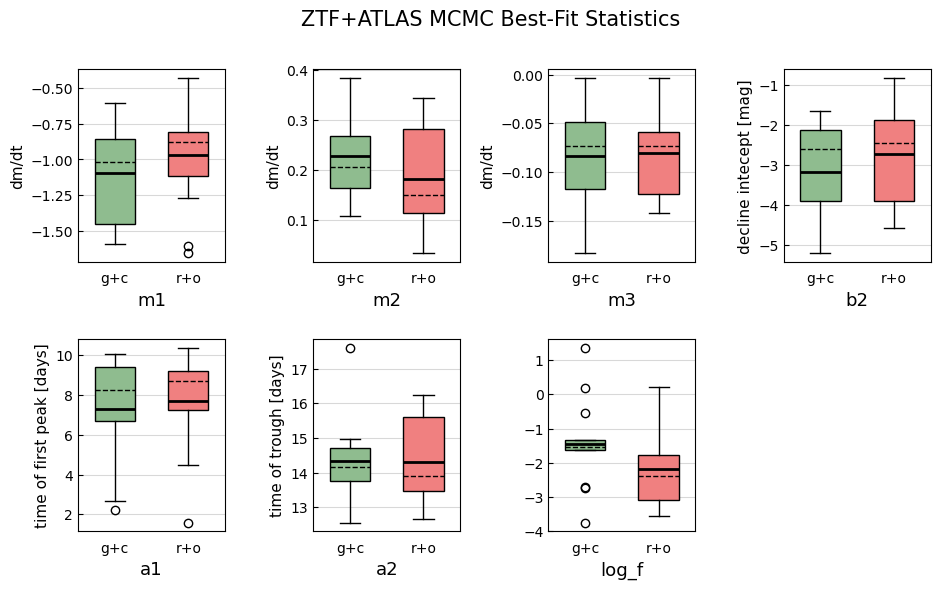

In [19]:
#making box and whisker plots and histograms
xlabels = ['m1', 'm2', 'm3', 'b2', 'a1', 'a2', 'log_f']
ylabels= ['dm/dt','dm/dt','dm/dt','decline intecept [mag]','time of first peak [days]', 'time of trough [days]']
labels = ['g+c','r+o']
boxprops = dict(linewidth=1.0, color='black')
medianprops = dict(linewidth=1.0, color='black', linestyle='--')
meanprops = dict(linewidth=2.0, color='black', linestyle='-')

def box_plot(data, loc=[0,0], label=labels, xlabel=xlabels):
    x1,x2 = loc[0],loc[1]
    bp = axs[x1,x2].boxplot(data, patch_artist=True,labels=label,boxprops=boxprops,medianprops=medianprops,meanprops=meanprops,widths=0.55, showmeans=True, meanline=True)
    colors = ['darkseagreen', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)  
    return bp

fig,axs = plt.subplots(2,4,figsize=(11,6))

box_plot([bestfit_df['m1_g'][bestfit_df['m1_g'].notna()],bestfit_df['m1_r'][bestfit_df['m1_r'].notna()]]
         ,loc=[0,0],label=labels,xlabel=xlabels[0])
box_plot([bestfit_df['m2_g'][bestfit_df['m2_g'].notna()],bestfit_df['m2_r'][bestfit_df['m2_r'].notna()]]
         ,loc=[0,1],label=labels,xlabel=xlabels[0])
box_plot([bestfit_df['m3_g'][bestfit_df['m3_g'].notna()],bestfit_df['m3_r'][bestfit_df['m3_r'].notna()]]
         ,loc=[0,2],label=labels,xlabel=xlabels[0])
box_plot([bestfit_df['b2_g'][bestfit_df['b2_g'].notna()],bestfit_df['b2_r'][bestfit_df['b2_r'].notna()]]
         ,loc=[0,3],label=labels,xlabel=xlabels[0])
box_plot([bestfit_df['a1_g'][bestfit_df['a1_g'].notna()],bestfit_df['a1_r'][bestfit_df['a1_r'].notna()]]
         ,loc=[1,0],label=labels,xlabel=xlabels[0])
box_plot([bestfit_df['a2_g'][bestfit_df['a2_g'].notna()],bestfit_df['a2_r'][bestfit_df['a2_r'].notna()]]
         ,loc=[1,1],label=labels,xlabel=xlabels[0])
box_plot([bestfit_df['log_f_g'][bestfit_df['log_f_g'].notna()],bestfit_df['log_f_r'][bestfit_df['log_f_r'].notna()]]
         ,loc=[1,2],label=labels,xlabel=xlabels[0])
axs[1,3].axis("off")

axs[0,0].set_xlabel(xlabels[0],fontsize=13)
axs[0,1].set_xlabel(xlabels[1],fontsize=13)
axs[0,2].set_xlabel(xlabels[2],fontsize=13)
axs[0,3].set_xlabel(xlabels[3],fontsize=13)
axs[1,0].set_xlabel(xlabels[4],fontsize=13)
axs[1,1].set_xlabel(xlabels[5],fontsize=13)
axs[1,2].set_xlabel(xlabels[6],fontsize=13)

axs[0,0].set_ylabel(ylabels[0],fontsize=11)
axs[0,1].set_ylabel(ylabels[1],fontsize=11)
axs[0,2].set_ylabel(ylabels[2],fontsize=11)
axs[0,3].set_ylabel(ylabels[3],fontsize=11)
axs[1,0].set_ylabel(ylabels[4],fontsize=11)
axs[1,1].set_ylabel(ylabels[5],fontsize=11)

axs[0,0].tick_params(axis="y",direction="in")
axs[0,0].tick_params(axis="x",top=False,bottom=False)
axs[0,0].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[0,1].tick_params(axis="y",direction="in")
axs[0,1].tick_params(axis="x",top=False,bottom=False)
axs[0,1].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[0,2].tick_params(axis="y",direction="in")
axs[0,2].tick_params(axis="x",top=False,bottom=False)
axs[0,2].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[0,3].tick_params(axis="y",direction="in")
axs[0,3].tick_params(axis="x",top=False,bottom=False)
axs[0,3].yaxis.grid(color='gray',alpha=0.3, linestyle='-')

axs[1,0].tick_params(axis="y",direction="in")
axs[1,0].tick_params(axis="x",top=False,bottom=False)
axs[1,0].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[1,1].tick_params(axis="y",direction="in")
axs[1,1].tick_params(axis="x",top=False,bottom=False)
axs[1,1].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[1,2].tick_params(axis="y",direction="in")
axs[1,2].tick_params(axis="x",top=False,bottom=False)
axs[1,2].yaxis.grid(color='gray',alpha=0.3, linestyle='-')


fig.subplots_adjust(hspace=0.4,wspace=0.6)
fig.suptitle('ZTF+ATLAS MCMC Best-Fit Statistics', fontsize=15)
plt.savefig(SAVE_DIR+'figures/boxwhisk_params.png',dpi=300)

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_58638/2846751569.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[x1,x2].boxplot(data, patch_artist=True,labels=label,boxprops=boxprops,medianprops=medianprops,meanprops=meanprops,widths=0.55, showmeans=True, meanline=True)
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_58638/2846751569.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[x1,x2].boxplot(data, patch_artist=True,labels=label,boxprops=boxprops,medianprops=medianprops,meanprops=meanprops,widths=0.55, showmeans=True, meanline=True)
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_58638/2846751569.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been 

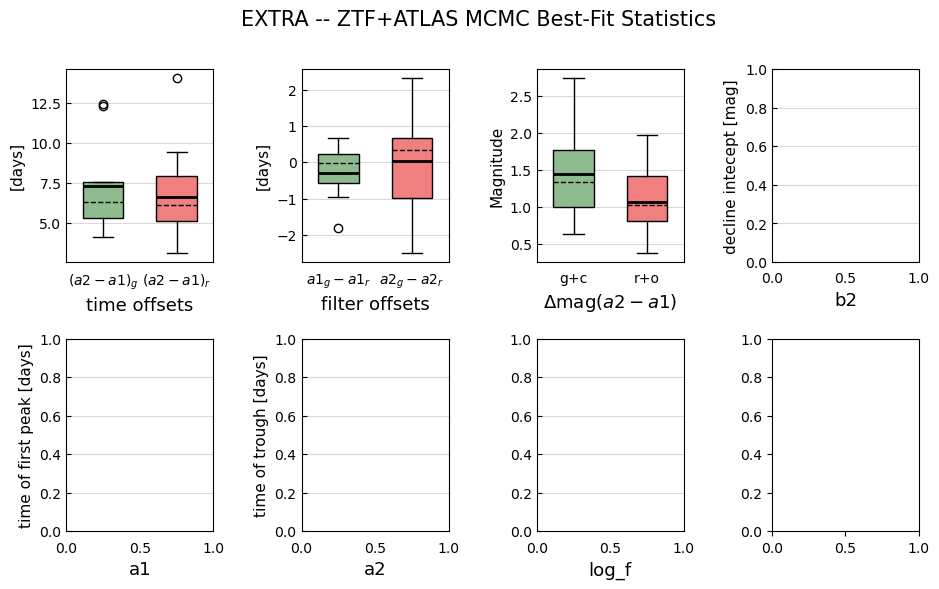

In [20]:
#making box and whisker plots and histograms for extra population stats
xlabels = ['time offsets', 'filter offsets', '$\Delta\mathrm{mag}(a2-a1)$', 'b2', 'a1', 'a2', 'log_f']
ylabels= ['[days]','[days]','Magnitude','decline intecept [mag]','time of first peak [days]', 'time of trough [days]']
labels = ['g+c','r+o']
boxprops = dict(linewidth=1.0, color='black')
medianprops = dict(linewidth=1.0, color='black', linestyle='--')
meanprops = dict(linewidth=2.0, color='black', linestyle='-')

def box_plot(data, loc=[0,0], label=labels, xlabel=xlabels):
    x1,x2 = loc[0],loc[1]
    bp = axs[x1,x2].boxplot(data, patch_artist=True,labels=label,boxprops=boxprops,medianprops=medianprops,meanprops=meanprops,widths=0.55, showmeans=True, meanline=True)
    colors = ['darkseagreen', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)  
    return bp

fig,axs = plt.subplots(2,4,figsize=(11,6))

box_plot([bestfit_df['a2g-a1g'][bestfit_df['a2g-a1g'].notna()],bestfit_df['a2r-a1r'][bestfit_df['a2r-a1r'].notna()]]
         ,loc=[0,0],label=['$(a2-a1)_g$','$(a2-a1)_r$'],xlabel=xlabels[0])
box_plot([bestfit_df['a1g-a1r'][bestfit_df['a1g-a1r'].notna()],bestfit_df['a2g-a2r'][bestfit_df['a2g-a2r'].notna()]]
         ,loc=[0,1],label=['$a1_g-a1_r$','$a2_g-a2_r$'],xlabel=xlabels[0])
box_plot([bestfit_df['mag_a2g-a1g'][bestfit_df['mag_a2g-a1g'].notna()],bestfit_df['mag_a2r-a1r'][bestfit_df['mag_a2r-a1r'].notna()]]
         ,loc=[0,2],label=labels,xlabel=[])
# box_plot([bestfit_df['b2_g'][bestfit_df['b2_g'].notna()],bestfit_df['b2_r'][bestfit_df['b2_r'].notna()]]
#          ,loc=[0,3],label=labels,xlabel=xlabels[0])
# box_plot([bestfit_df['a1_g'][bestfit_df['a1_g'].notna()],bestfit_df['a1_r'][bestfit_df['a1_r'].notna()]]
#          ,loc=[1,0],label=labels,xlabel=xlabels[0])
# box_plot([bestfit_df['a2_g'][bestfit_df['a2_g'].notna()],bestfit_df['a2_r'][bestfit_df['a2_r'].notna()]]
#          ,loc=[1,1],label=labels,xlabel=xlabels[0])
# box_plot([bestfit_df['log_f_g'][bestfit_df['log_f_g'].notna()],bestfit_df['log_f_r'][bestfit_df['log_f_r'].notna()]]
#          ,loc=[1,2],label=labels,xlabel=xlabels[0])
# axs[1,3].axis("off")

axs[0,0].set_xlabel(xlabels[0],fontsize=13)
axs[0,1].set_xlabel(xlabels[1],fontsize=13)
axs[0,2].set_xlabel(xlabels[2],fontsize=13)
axs[0,3].set_xlabel(xlabels[3],fontsize=13)
axs[1,0].set_xlabel(xlabels[4],fontsize=13)
axs[1,1].set_xlabel(xlabels[5],fontsize=13)
axs[1,2].set_xlabel(xlabels[6],fontsize=13)

axs[0,0].set_ylabel(ylabels[0],fontsize=11)
axs[0,1].set_ylabel(ylabels[1],fontsize=11)
axs[0,2].set_ylabel(ylabels[2],fontsize=11)
axs[0,3].set_ylabel(ylabels[3],fontsize=11)
axs[1,0].set_ylabel(ylabels[4],fontsize=11)
axs[1,1].set_ylabel(ylabels[5],fontsize=11)

axs[0,0].tick_params(axis="y",direction="in")
axs[0,0].tick_params(axis="x",top=False,bottom=False)
axs[0,0].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[0,1].tick_params(axis="y",direction="in")
axs[0,1].tick_params(axis="x",top=False,bottom=False)
axs[0,1].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[0,2].tick_params(axis="y",direction="in")
axs[0,2].tick_params(axis="x",top=False,bottom=False)
axs[0,2].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[0,3].tick_params(axis="y",direction="in")
axs[0,3].tick_params(axis="x",top=False,bottom=False)
axs[0,3].yaxis.grid(color='gray',alpha=0.3, linestyle='-')

axs[1,0].tick_params(axis="y",direction="in")
axs[1,0].tick_params(axis="x",top=False,bottom=False)
axs[1,0].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[1,1].tick_params(axis="y",direction="in")
axs[1,1].tick_params(axis="x",top=False,bottom=False)
axs[1,1].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[1,2].tick_params(axis="y",direction="in")
axs[1,2].tick_params(axis="x",top=False,bottom=False)
axs[1,2].yaxis.grid(color='gray',alpha=0.3, linestyle='-')


fig.subplots_adjust(hspace=0.4,wspace=0.6)
fig.suptitle('EXTRA -- ZTF+ATLAS MCMC Best-Fit Statistics', fontsize=15)
plt.savefig(SAVE_DIR+'figures/boxwhisk_extra_params.png',dpi=300)

In [370]:
df_str='sn19rwd'
best = bestfit_df.loc[bestfit_df['SN_ID']==df_str, ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']].iloc[0].to_numpy()
lower_fit = low_err_df.loc[low_err_df['SN_ID']==df_str, ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']].iloc[0].to_numpy()
upper_fit = upp_err_df.loc[upp_err_df['SN_ID']==df_str, ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']].iloc[0].to_numpy()
print(best)
print(lower_fit)
print(upper_fit)

[-0.97959005  0.14217772 -0.04914604 -1.92108806  8.26181182 14.16397158
 -2.70152925]
[-1.66814267  0.1238915  -0.15729096 -2.10328829  8.10877842 13.63967589
 -3.52576076]
[-1.66814267  0.1238915  -0.15729096 -2.10328829  8.10877842 13.63967589
 -3.52576076]


/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_55637/2541444322.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_a1_g = float(stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['mean'])
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_55637/2541444322.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_a2_g = float(stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['mean'])


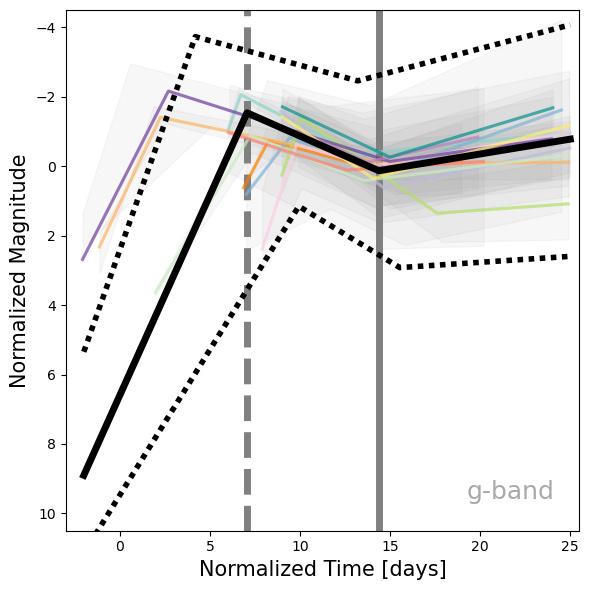

In [377]:
# PLOTTING THE MEAN FIT OVER THE BESTFITS
mean_x = np.arange(-2,25,0.001)

fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
for i,df in enumerate(df_sub_ls):
    df_str =  df_str_list[i]
    g_df = df[(df['filter']=='ZTF_g') | (df['filter']=='c')]
    x_plt = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)

    best = bestfit_df.loc[bestfit_df['SN_ID']==df_str, ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']].iloc[0].dropna().to_numpy()
    lower_bound = low_err_df.loc[low_err_df['SN_ID']==df_str, ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']].iloc[0].dropna().to_numpy()
    upper_bound = upp_err_df.loc[upp_err_df['SN_ID']==df_str, ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']].iloc[0].dropna().to_numpy()
    
    #plotting mcmc results
    plt.plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], alpha=0.7, linewidth=2.25)# linestyle=ls[i])
    lower_curve = np.array([model(lower_bound, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt])
    upper_curve = np.array([model(upper_bound, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt])
    plt.fill_between(x_plt, lower_curve, upper_curve, color='gray', alpha=0.06)

#overall mean best fit
mean_fit_g = stats_df[stats_df['filter']=='g']['mean']
lower_mean =  np.array([model(stats_df[stats_df['filter']=='g']['mean']-stats_df[stats_df['filter']=='g']['std'],v,r1=True) for v in mean_x])
upper_mean =  np.array([model(stats_df[stats_df['filter']=='g']['mean']+stats_df[stats_df['filter']=='g']['std'],v,r1=True) for v in mean_x])
plt.plot(mean_x, np.array([model(mean_fit_g, v, r1=True) for v in mean_x]),c='black', label='Mean Best Fit', alpha=1.0, linewidth=5.0)
plt.plot(mean_x, lower_mean, color='black', linestyle=(0,(1,1)), alpha=1.0, linewidth=4.0)
plt.plot(mean_x, upper_mean, color='black', linestyle=(0,(1,1)), alpha=1.0, linewidth=4.0)

mean_a1_g = float(stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['mean'])
mean_a2_g = float(stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['mean'])
plt.axvline(mean_a1_g,alpha=1.0, color='gray', linestyle='dashed', linewidth=5, label='Mean a1', zorder=0)
plt.axvline(mean_a2_g,alpha=1.0, color='gray', linestyle='solid', linewidth=5, label='Mean a2', zorder=0)

bbox = dict(facecolor='white', edgecolor='white',alpha=0.85)
plt.annotate('g-band',xy=(0.78,0.06),xycoords='axes fraction',color='darkgray',fontsize=18, bbox=bbox)

plt.xlabel('Normalized Time [days]', fontsize=15)
plt.ylabel('Normalized Magnitude', fontsize=15)
# plt.title('MCMC Mean Best Fit for all g-band SNe', fontsize=15)
plt.ylim(10.5,-4.5)
plt.xlim(-3,25.5)
# ax.legend(handles, labels[0:15], loc='center left', bbox_to_anchor=(1, 0.4),frameon=False, fontsize=12)

plt.tight_layout()
plt.savefig(SAVE_DIR+'/figures/mean_mcmc_fits_g.png', dpi=300)

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_55637/4008686303.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_a1_r = float(stats_df[stats_df['filter']=='r'].loc[stats_df['param']=='a1']['mean'])
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_55637/4008686303.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_a2_r = float(stats_df[stats_df['filter']=='r'].loc[stats_df['param']=='a2']['mean'])


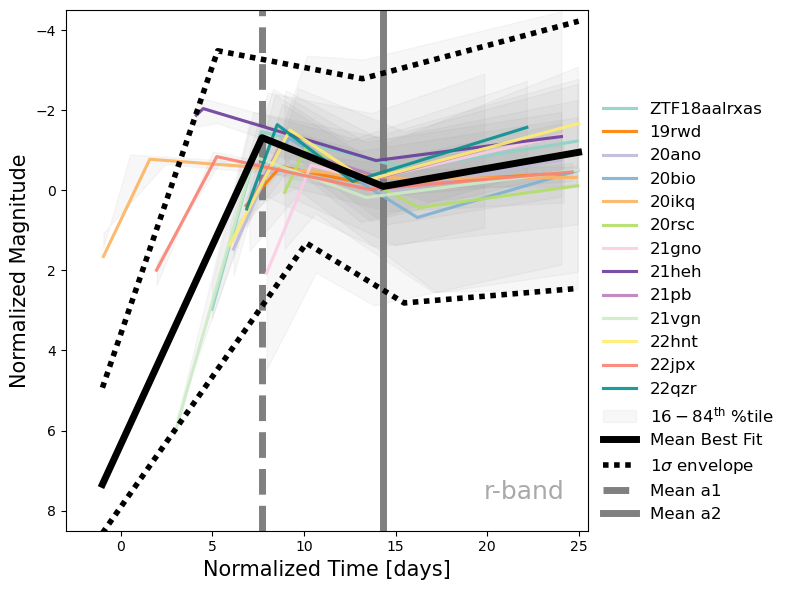

In [381]:
mean_x = np.arange(-1,25,0.01)

plt.figure(figsize=(8,6))
ax = plt.subplot(111)
for i,df in enumerate(df_sub_ls):
    df_str = df_str_list[i]
    r_df = df[(df['filter']=='ZTF_r') | (df['filter']=='o')]
    x_plt = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)

    best = bestfit_df.loc[bestfit_df['SN_ID']==df_str, ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']].iloc[0].dropna().to_numpy()
    lower_bound = low_err_df.loc[low_err_df['SN_ID']==df_str, ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']].iloc[0].dropna().to_numpy()
    upper_bound = upp_err_df.loc[upp_err_df['SN_ID']==df_str, ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']].iloc[0].dropna().to_numpy()
    
    #plotting mcmc results
    plt.plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], alpha=0.9, linewidth=2.25)# linestyle=ls[i])
    lower_curve = np.array([model(lower_bound, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt])
    upper_curve = np.array([model(upper_bound, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt])
    plt.fill_between(x_plt, lower_curve, upper_curve, color='gray', alpha=0.06, label='$16-84^{\mathrm{th}}$ %tile')

#overall mean best fit
mean_fit_r = stats_df[stats_df['filter']=='r']['mean']
lower_mean =  np.array([model(stats_df[stats_df['filter']=='r']['mean']-stats_df[stats_df['filter']=='r']['std'],v,r1=True) for v in mean_x])
upper_mean =  np.array([model(stats_df[stats_df['filter']=='r']['mean']+stats_df[stats_df['filter']=='r']['std'],v,r1=True) for v in mean_x])
plt.plot(mean_x, np.array([model(mean_fit_r, v, r1=True) for v in mean_x]),c='black', label='Mean Best Fit', alpha=1.0, linewidth=5.0)
plt.plot(mean_x, lower_mean, color='black', linestyle=(0,(1,1)), alpha=1.0, linewidth=4)
plt.plot(mean_x, upper_mean, color='black', linestyle=(0,(1,1)), alpha=1.0, linewidth=4, label='$1\sigma$ envelope')

mean_a1_r = float(stats_df[stats_df['filter']=='r'].loc[stats_df['param']=='a1']['mean'])
mean_a2_r = float(stats_df[stats_df['filter']=='r'].loc[stats_df['param']=='a2']['mean'])
plt.axvline(mean_a1_r,alpha=1.0, color='gray', linestyle='dashed', linewidth=5, label='Mean a1', zorder=0)
plt.axvline(mean_a2_r,alpha=1.0, color='gray', linestyle='solid', linewidth=5, label='Mean a2', zorder=0)

bbox = dict(facecolor='white', edgecolor='white',alpha=0.85)
plt.annotate('r-band',xy=(0.8,0.06),xycoords='axes fraction',color='darkgray',fontsize=18, bbox=bbox)

plt.xlabel('Normalized Time [days]', fontsize=15)
plt.ylabel('Normalized Magnitude', fontsize=15)
# plt.title('MCMC Mean Best Fit for all r-band SNe', fontsize=15)
plt.ylim(8.5,-4.5)
plt.xlim(-3,25.5)
handles, labels = ax.get_legend_handles_labels()
h, l = handles[:26:2], labels[:26:2]
h2, l2 = handles[25:], labels[25:]
hand, lab = h+h2, l+l2
ax.legend(hand, lab, loc='center left', bbox_to_anchor=(1, 0.42),frameon=False, fontsize=12)
plt.tight_layout()
plt.savefig(SAVE_DIR+'/figures/mean_mcmc_fits_r.png', dpi=300)

In [23]:
# plot_names = ['ZTF18aalrxas', '19rwd', '20ano','20bio','20ikq','20rsc','21gno','21heh','21vgn','22hnt','22jpx','22qzr']

# fig, axs = plt.subplots(4,3, figsize=(9,12))
# locs = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2],[3,0],[3,1],[3,2]]

# for i,df in enumerate(df_sub_ls):
#     df_str = df_str_list[i]
#     g_df = df[(df['filter']=='ZTF_g') | (df['filter']=='c')]
#     x_plt = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)

#     best = np.array(all_fits_g[i]).T[0] #bestfit values
#     lower_bound = np.array(all_fits_g[i]).T[0] - np.array(all_fits_g[i]).T[1] #50th ptile - diff_16ptile
#     upper_bound = np.array(all_fits_g[i]).T[0] + np.array(all_fits_g[i]).T[2] #50th ptile + diff_84ptile
#     a1s.append(best[-3])
#     a2s.append(best[-2])
    
#     #plotting mcmc results
#     axs[locs[i][0],locs[i][1]].plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], linewidth=2.25)# linestyle=ls[i])
#     axs[locs[i][0],locs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a1_g']), color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
#     axs[locs[i][0],locs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a2_g']), color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

#     #plotting ztf data
#     x,y,yerr = np.array(g_df['norm_t']),np.array(g_df['norm_m']),np.array(g_df['mag_err_all'])
#     axs[locs[i][0],locs[i][1]].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0, label='g+c') #ztf errors,

#     bbox = dict(facecolor='white', edgecolor='white',alpha=0.85)
#     axs[locs[i][0],locs[i][1]].annotate(plot_names[i],xy=(0.08,0.12),xycoords='axes fraction',color=colors[i],fontsize=14, bbox=bbox)

#     # axs[locs[i][0],locs[i][1]].set_xlabel('Normalized Time [days]')
#     # axs[locs[i][0],locs[i][1]].set_ylabel('Normalized Magnitude')
#     axs[locs[i][0],locs[i][1]].set_ylim(max(y)+2, min(y)-1)
#     axs[locs[i][0],locs[i][1]].xaxis.set_minor_locator(AutoMinorLocator())
#     axs[locs[i][0],locs[i][1]].yaxis.set_minor_locator(AutoMinorLocator())
#     axs[locs[i][0],locs[i][1]].tick_params(which="both",top=False, labeltop=False, bottom=True, labelbottom=True, left=True, right=False, direction="in",zorder=0)

# axs[3,0].set_xlabel('Normalized Time [days]')
# axs[3,1].set_xlabel('Normalized Time [days]')
# axs[3,2].set_xlabel('Normalized Time [days]')

# axs[0,0].set_ylabel('Normalized Magnitude')
# axs[1,0].set_ylabel('Normalized Magnitude')
# axs[2,0].set_ylabel('Normalized Magnitude')
# axs[3,0].set_ylabel('Normalized Magnitude')


# handles, labels = axs[3,0].get_legend_handles_labels()
# fig.legend(handles[1:], labels[1:], loc='center left', bbox_to_anchor=(.835, 0.095),fontsize='x-large',markerscale=1.5,
#                 frameon=True,fancybox=False,framealpha=1.0,edgecolor='darkgray')
# plt.tight_layout()
# plt.savefig(SAVE_DIR+'/figures/individ_mcmc_g_fits_subplot.png', dpi=300)

In [24]:
# fig, axs = plt.subplots(4,3, figsize=(9,12))
# locs = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2],[3,0],[3,1],[3,2]]

# for i,df in enumerate(df_sub_ls):
#     df_str = df_str_list[i]
#     r_df = df[(df['filter']=='ZTF_r') | (df['filter']=='o')]
#     x_plt = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)

#     best = np.array(all_fits_r[i]).T[0] #bestfit values
#     lower_bound = np.array(all_fits_r[i]).T[0] - np.array(all_fits_r[i]).T[1] #50th ptile - diff_16ptile
#     upper_bound = np.array(all_fits_r[i]).T[0] + np.array(all_fits_r[i]).T[2] #50th ptile + diff_84ptile
#     a1s.append(best[-3])
#     a2s.append(best[-2])
    
#     #plotting mcmc results
#     axs[locs[i][0],locs[i][1]].plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], linewidth=2.25)# linestyle=ls[i])
#     axs[locs[i][0],locs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a1_r']), color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
#     axs[locs[i][0],locs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a2_r']), color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

#     #plotting ztf data
#     x,y,yerr = np.array(r_df['norm_t']),np.array(r_df['norm_m']),np.array(r_df['mag_err_all'])
#     axs[locs[i][0],locs[i][1]].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0, label='r+o') #ztf errors,

#     bbox = dict(facecolor='white', edgecolor='white',alpha=0.85)
#     axs[locs[i][0],locs[i][1]].annotate(plot_names[i],xy=(0.08,0.12),xycoords='axes fraction',color=colors[i],fontsize=14, bbox=bbox)

#     # axs[locs[i][0],locs[i][1]].set_xlabel('Normalized Time [days]')
#     # axs[locs[i][0],locs[i][1]].set_ylabel('Normalized Magnitude')
#     axs[locs[i][0],locs[i][1]].set_ylim(max(y)+2, min(y)-1)
#     axs[locs[i][0],locs[i][1]].xaxis.set_minor_locator(AutoMinorLocator())
#     axs[locs[i][0],locs[i][1]].yaxis.set_minor_locator(AutoMinorLocator())
#     axs[locs[i][0],locs[i][1]].tick_params(which="both",top=False, labeltop=False, bottom=True, labelbottom=True, left=True, right=False, direction="in",zorder=0)


# axs[3,0].set_xlabel('Normalized Time [days]')
# axs[3,1].set_xlabel('Normalized Time [days]')
# axs[3,2].set_xlabel('Normalized Time [days]')

# axs[0,0].set_ylabel('Normalized Magnitude')
# axs[1,0].set_ylabel('Normalized Magnitude')
# axs[2,0].set_ylabel('Normalized Magnitude')
# axs[3,0].set_ylabel('Normalized Magnitude')


# handles, labels = axs[3,0].get_legend_handles_labels()
# fig.legend(handles[1:], labels[1:], loc='center left', bbox_to_anchor=(.835, 0.095),fontsize='x-large',markerscale=1.5,
#                 frameon=True,fancybox=False,framealpha=1.0,edgecolor='darkgray')
# plt.tight_layout()
# plt.savefig(SAVE_DIR+'/figures/individ_mcmc_r_fits_subplot.png', dpi=300)

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_55637/803216860.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


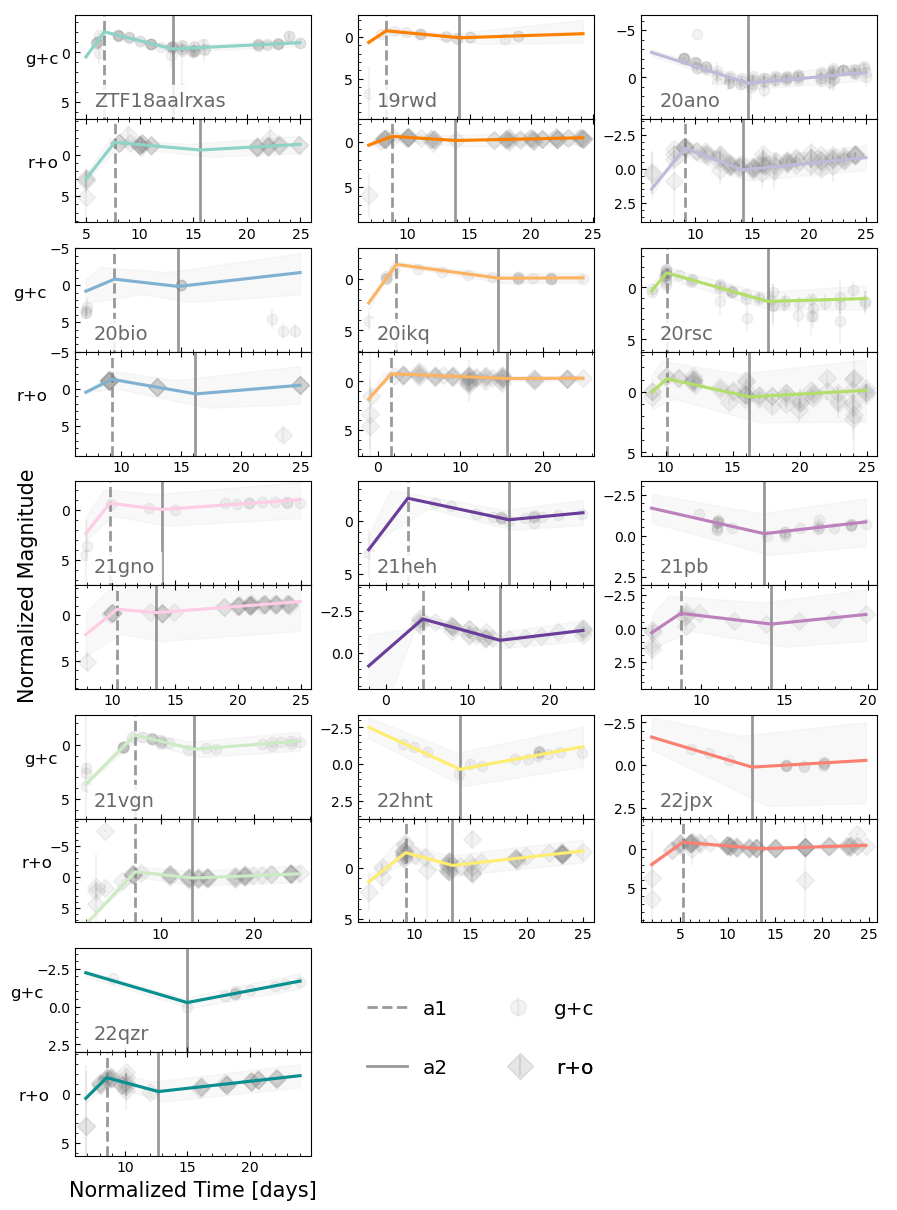

In [396]:
%matplotlib inline
# COMBIINING THE SUBPOTS TO COMPARE B/W G AND R RESULTS

gridspec = dict(hspace=0.0, wspace=0.2, height_ratios=[1,1,0.25,1,1,0.25,1,1,0.25,1,1,0.25,1,1])
fig, axs = plt.subplots(14,3, figsize=(9,12), sharex=False, gridspec_kw=gridspec)
glocs = [[0,0],[0,1],[0,2],[3,0],[3,1],[3,2],[6,0],[6,1],[6,2],[9,0],[9,1],[9,2],[12,0],[12,1]]
rlocs = [[1,0],[1,1],[1,2],[4,0],[4,1],[4,2],[7,0],[7,1],[7,2],[10,0],[10,1],[10,2],[13,0],[13,1]]
elocs = [[2,0],[2,1],[2,2],[5,0],[5,1],[5,2],[8,0],[8,1],[8,2],[11,0],[11,1]]

for i,df in enumerate(df_sub_ls):
    df_str = df_str_list[i]
    g_df = df[(df['filter']=='ZTF_g') | (df['filter']=='c')]
    r_df = df[(df['filter']=='ZTF_r') | (df['filter']=='o')]

    x_plt = np.arange(min(list(g_df['norm_t'])+list(r_df['norm_t'])),max(list(g_df['norm_t'])+list(r_df['norm_t'])),0.01)

    ################## g band
    best = bestfit_df.loc[bestfit_df['SN_ID']==df_str, ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']].iloc[0].dropna().to_numpy()
    lower_bound = low_err_df.loc[low_err_df['SN_ID']==df_str, ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']].iloc[0].dropna().to_numpy()
    upper_bound = upp_err_df.loc[upp_err_df['SN_ID']==df_str, ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']].iloc[0].dropna().to_numpy()
    
    #plotting mcmc results
    axs[glocs[i][0],glocs[i][1]].plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], linewidth=2.25)# linestyle=ls[i])
    lower_curve = np.array([model(lower_bound, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt])
    upper_curve = np.array([model(upper_bound, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt])
    axs[glocs[i][0],glocs[i][1]].fill_between(x_plt, lower_curve, upper_curve, color='gray', alpha=0.05, zorder=0)
    axs[glocs[i][0],glocs[i][1]].axvline(float(bestfit_df.loc[bestfit_df['SN_ID']==df_str, 'a1_g'].iloc[0]), color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
    axs[glocs[i][0],glocs[i][1]].axvline(float(bestfit_df.loc[bestfit_df['SN_ID']==df_str, 'a2_g'].iloc[0]), color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

    #plotting ztf data
    x,y,yerr = np.array(g_df['norm_t']),np.array(g_df['norm_m']),np.array(g_df['mag_err_all'])
    axs[glocs[i][0],glocs[i][1]].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0, label='g+c') #ztf errors,

    axs[glocs[i][0],glocs[i][1]].set_ylim(max(y)+3, min(y)-2)
    axs[glocs[i][0],glocs[i][1]].xaxis.set_minor_locator(AutoMinorLocator())
    axs[glocs[i][0],glocs[i][1]].yaxis.set_minor_locator(AutoMinorLocator())
    axs[glocs[i][0],glocs[i][1]].tick_params(which="both",top=False, labeltop=False, bottom=True, labelbottom=False, left=True, right=False, direction="in",zorder=0)

    ################## r band
    best_r = bestfit_df.loc[bestfit_df['SN_ID']==df_str, ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']].iloc[0].dropna().to_numpy()
    lower_bound_r = low_err_df.loc[low_err_df['SN_ID']==df_str, ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']].iloc[0].dropna().to_numpy()
    upper_bound_r = upp_err_df.loc[upp_err_df['SN_ID']==df_str, ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']].iloc[0].dropna().to_numpy()
    
    #plotting mcmc results
    axs[rlocs[i][0],rlocs[i][1]].plot(x_plt, np.array([model(best_r, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], linewidth=2.25)# linestyle=ls[i])
    lower_curve_r = np.array([model(lower_bound_r, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt])
    upper_curve_r = np.array([model(upper_bound_r, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt])
    axs[rlocs[i][0],rlocs[i][1]].fill_between(x_plt, lower_curve_r, upper_curve_r, color='gray', alpha=0.05, zorder=0)
    axs[rlocs[i][0],rlocs[i][1]].axvline(bestfit_df.loc[bestfit_df['SN_ID']==df_str, 'a1_r'].iloc[0], color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
    axs[rlocs[i][0],rlocs[i][1]].axvline(bestfit_df.loc[bestfit_df['SN_ID']==df_str, 'a2_r'].iloc[0], color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

    #plotting ztf data
    xr,yr,yerrr = np.array(r_df['norm_t']),np.array(r_df['norm_m']),np.array(r_df['mag_err_all'])
    axs[rlocs[i][0],rlocs[i][1]].errorbar(xr, yr, yerrr, linestyle='', marker='D', color='gray', alpha=0.1, markersize=9, zorder=0, label='r+o') #ztf errors,

    axs[rlocs[i][0],rlocs[i][1]].set_ylim(max(yr)+3, min(yr)-2)
    axs[rlocs[i][0],rlocs[i][1]].xaxis.set_minor_locator(AutoMinorLocator())
    axs[rlocs[i][0],rlocs[i][1]].yaxis.set_minor_locator(AutoMinorLocator())
    axs[rlocs[i][0],rlocs[i][1]].tick_params(which="both",top=True, labeltop=False, bottom=True, labelbottom=True, left=True, right=False, direction="in",zorder=0)

    ########## labels
    bbox = dict(facecolor='white', edgecolor='white',alpha=0.85)
    axs[glocs[i][0],glocs[i][1]].annotate(plot_names[i],xy=(0.08,0.12),xycoords='axes fraction',color='dimgray',fontsize=14, bbox=bbox)

for i,e in enumerate(elocs):
    axs[e[0],e[1]].set_visible(False)

axs[12,1].axis("off")
axs[12,2].axis("off")
axs[13,1].axis("off")
axs[13,2].axis("off")
axs[11,1].axis("off")
axs[11,2].axis("off")

axs[3,0].set_ylim(9,-5)
axs[4,0].set_ylim(9,-5)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
axs[13,0].set_xlabel("Normalized Time [days]", fontsize=15)
plt.ylabel("Normalized Magnitude", fontsize=15)
axs[0,0].set_ylabel('g+c', rotation=0, labelpad=14, fontsize=12)
axs[1,0].set_ylabel("r+o", rotation=0, labelpad=13, fontsize=12)
axs[3,0].set_ylabel('g+c', rotation=0, labelpad=14, fontsize=12)
axs[4,0].set_ylabel("r+o", rotation=0, labelpad=13, fontsize=12)
axs[9,0].set_ylabel('g+c', rotation=0, labelpad=15, fontsize=12)
axs[10,0].set_ylabel("r+o", rotation=0, labelpad=9, fontsize=12)
axs[12,0].set_ylabel('g+c', rotation=0, labelpad=7, fontsize=12)
axs[13,0].set_ylabel("r+o", rotation=0, labelpad=20, fontsize=12)

handles, labels = axs[12,0].get_legend_handles_labels()
fig.legend(handles[1:], labels[1:], loc='center left', bbox_to_anchor=(0.385, 0.13),fontsize='x-large',markerscale=1.5,
                frameon=False,fancybox=False,ncols=2,labelspacing=2.0,columnspacing=2.5)

h1, l1 = axs[10,2].get_legend_handles_labels()
h, l = h1[3:], l1[3:]
leg1 = axs[10,2].legend(h, l, loc='center left', bbox_to_anchor=(-0.675, -1.4),fontsize='x-large',markerscale=1.5,
                frameon=False,fancybox=False,)
axs[10,2].add_artist(leg1)

fig.tight_layout()
plt.savefig(SAVE_DIR+'/figures/individ_mcmc_fits_subplot_both_bands.png', dpi=300, bbox_inches='tight', pad_inches=0.2)

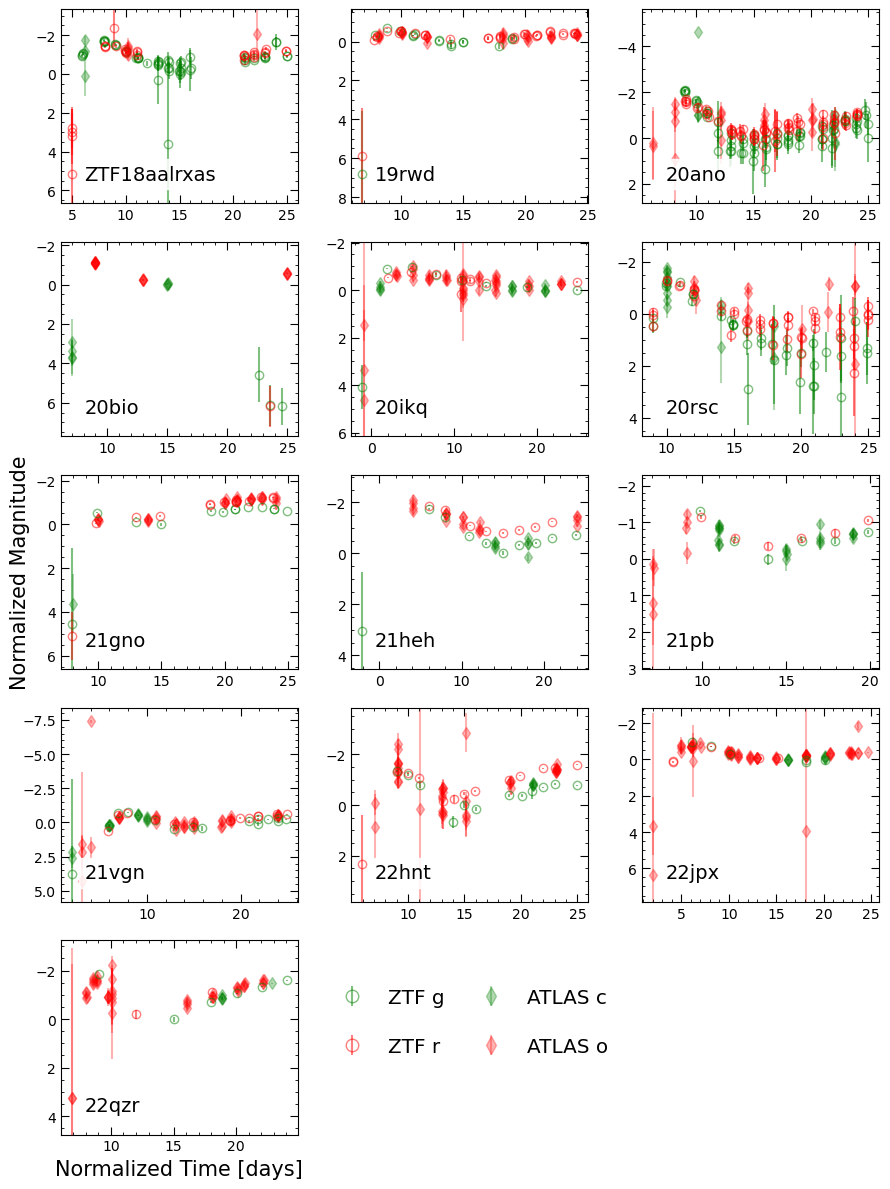

In [26]:
fig, axs = plt.subplots(5,3, figsize=(9,12))
locs = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2],[3,0],[3,1],[3,2],[4,0]]

for i,df in enumerate(df_sub_ls):
    axs[locs[i][0],locs[i][1]].errorbar(df[df['filter']=='ZTF_g']['norm_t'], df[df['filter']=='ZTF_g']['norm_m'],df[df['filter']=='ZTF_g']['mag_err_all'],
                 markeredgecolor='green',markerfacecolor='none',ecolor='green',label='ZTF g',alpha=0.5,linestyle='',marker='o')
    axs[locs[i][0],locs[i][1]].errorbar(df[df['filter']=='ZTF_r']['norm_t'], df[df['filter']=='ZTF_r']['norm_m'],df[df['filter']=='ZTF_r']['mag_err_all'],
                 markeredgecolor='red',markerfacecolor='none',ecolor='red',label='ZTF r',alpha=0.5,linestyle='',marker='o')
    axs[locs[i][0],locs[i][1]].errorbar(df[df['filter']=='c']['norm_t'], df[df['filter']=='c']['norm_m'],df[df['filter']=='c']['mag_err_all'],
                 color='green', marker='d',label='ATLAS c',alpha=0.3,linestyle='',zorder=0)
    axs[locs[i][0],locs[i][1]].errorbar(df[df['filter']=='o']['norm_t'], df[df['filter']=='o']['norm_m'],df[df['filter']=='o']['mag_err_all'],
                 color='red', marker='d', label='ATLAS o',alpha=0.3,linestyle='',zorder=0)
    
    y_mins = [df[df['filter']=='ZTF_g']['norm_m'].min(), df[df['filter']=='ZTF_r']['norm_m'].min(), df[df['filter']=='c']['norm_m'].min(), df[df['filter']=='o']['norm_m'].min()]
    y_maxs = [df[df['filter']=='ZTF_g']['norm_m'].max(), df[df['filter']=='ZTF_r']['norm_m'].max(), df[df['filter']=='c']['norm_m'].max(), df[df['filter']=='o']['norm_m'].max()]
    
    axs[locs[i][0],locs[i][1]].set_ylim(max(y_maxs)+1.5, min(y_mins)-1)
    axs[locs[i][0],locs[i][1]].xaxis.set_minor_locator(AutoMinorLocator())
    axs[locs[i][0],locs[i][1]].yaxis.set_minor_locator(AutoMinorLocator())
    axs[locs[i][0],locs[i][1]].tick_params(which="both", top=True, labeltop=False, bottom=True, labelbottom=True, left=True, right=True, direction="in")
    axs[locs[i][0],locs[i][1]].xaxis.set_tick_params(length=6)
    axs[locs[i][0],locs[i][1]].yaxis.set_tick_params(length=6)
    
    bbox = dict(facecolor='white', edgecolor='white',alpha=0.85)
    axs[locs[i][0],locs[i][1]].annotate(plot_names[i],xy=(0.1,0.12),xycoords='axes fraction',color='k',fontsize=14,bbox=bbox)

axs[4,1].axis("off")
axs[4,2].axis("off")

# axs[4,0].set_xlabel('Normalized Time [days]')
axs[4,0].set_xlabel('Normalized Time [days]', fontsize=15)
# axs[3,2].set_xlabel('Normalized Time [days]')

axs[2,0].set_ylabel('Normalized Magnitude', fontsize=15)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[0:4], labels[0:4], loc='lower center', bbox_to_anchor=(0.528, 0.1), ncol=2, fontsize='x-large',markerscale=1.5,
                frameon=False,fancybox=False,framealpha=1.0,edgecolor='darkgray', labelspacing=1.5, columnspacing=1.3)
fig.tight_layout()
plt.savefig(SAVE_DIR+'/figures/individ_fp_lcs_subplot.png',dpi=300)

In [1124]:
#############################
#  making absolute mag plots
#############################

In [259]:
xlims_jd_dict = {'snztf18':[24+2.4582e6, 65+2.4582e6],
               'sn19rwd':[760+2.458e6, 810+2.458e6],
               'sn20bio':[2458873.5, 2458920.5],
               'sn20ano':[868+2.458e6, 915+2.458e6],
               'sn20ikq':[-35+2.459e6, 15+2.459e6],
               'sn20rsc':[75+2.459e6, 107+2.459e6],
               'sn21gno':[290+2.459e6, 330+2.459e6],
               'sn21heh':[2459290.5, 2459340.5],
               'sn21vgn':[2459430.5, 2459480.5],
               'sn22hnt':[2459680.5, 2459730.5],
               'sn22jpx':[2459705.5, 2459740.5],
               'sn22qzr':[795+2.459e6, 875+2.459e6],
               'sn21pb':[18+2.4592e6, 60+2.4592e6],
                }

xlims_mjd_dict = {}
for k in xlims_jd_dict.keys():
    lims = [val-2400000.5 for val in xlims_jd_dict[k]]
    xlims_mjd_dict.update({k:lims})

xlims_mjd_dict

{'snztf18': [58223.5, 58264.5],
 'sn19rwd': [58759.5, 58809.5],
 'sn20bio': [58873.0, 58920.0],
 'sn20ano': [58867.5, 58914.5],
 'sn20ikq': [58964.5, 59014.5],
 'sn20rsc': [59074.5, 59106.5],
 'sn21gno': [59289.5, 59329.5],
 'sn21heh': [59290.0, 59340.0],
 'sn21vgn': [59430.0, 59480.0],
 'sn22hnt': [59680.0, 59730.0],
 'sn22jpx': [59705.0, 59740.0],
 'sn22qzr': [59794.5, 59874.5],
 'sn21pb': [59217.5, 59259.5]}

In [260]:
# read in the CLEANED AND AVERAGED data 
snztf18_full = pd.read_csv('./cleaning/outputs/snztf18_cleaned_binned_cut.csv')
sn19rwd_full = pd.read_csv('./cleaning/outputs/sn19rwd_cleaned_binned_cut.csv')
sn20bio_full = pd.read_csv('./cleaning/outputs/sn20bio_cleaned_binned_cut.csv')
sn21gno_full = pd.read_csv('./cleaning/outputs/sn21gno_cleaned_binned_cut.csv')
sn21heh_full = pd.read_csv('./cleaning/outputs/sn21heh_cleaned_binned_cut.csv')
sn21vgn_full = pd.read_csv('./cleaning/outputs/sn21vgn_cleaned_binned_cut.csv')
sn22hnt_full = pd.read_csv('./cleaning/outputs/sn22hnt_cleaned_binned_cut.csv')
sn22jpx_full = pd.read_csv('./cleaning/outputs/sn22jpx_cleaned_binned_cut.csv')
sn22qzr_full = pd.read_csv('./cleaning/outputs/sn22qzr_cleaned_binned_cut.csv')
# # added later
sn20ano_full = pd.read_csv('./cleaning/outputs/sn20ano_cleaned_binned_cut.csv',)
sn20ikq_full = pd.read_csv('./cleaning/outputs/sn20ikq_cleaned_binned_cut.csv',)
sn20rsc_full = pd.read_csv('./cleaning/outputs/sn20rsc_cleaned_binned_cut.csv',)
sn21pb_full =  pd.read_csv('./cleaning/outputs/sn21pb_cleaned_binned_cut.csv',)

df_list_full = [snztf18_full,sn19rwd_full,sn20ano_full,sn20bio_full,sn20ikq_full,sn20rsc_full,sn21gno_full,sn21heh_full,
           sn21pb_full, sn21vgn_full,sn22hnt_full,sn22jpx_full,sn22qzr_full]

def slice_df(df,mjd_lims=[0,0]):
    low = mjd_lims[0]
    high = mjd_lims[1]
    return df[(low<=df['mjd']) & (df['mjd']<=high) & (df['mag']>0)].reset_index(drop=True)

snztf18_cut = slice_df(snztf18_full,xlims_mjd_dict['snztf18'])
sn19rwd_cut = slice_df(sn19rwd_full,xlims_mjd_dict['sn19rwd'])
sn20ano_cut = slice_df(sn20ano_full,xlims_mjd_dict['sn20ano'])
sn20bio_cut = slice_df(sn20bio_full,xlims_mjd_dict['sn20bio'])
sn20ikq_cut = slice_df(sn20ikq_full,xlims_mjd_dict['sn20ikq'])
sn20rsc_cut = slice_df(sn20rsc_full,xlims_mjd_dict['sn20rsc'])
sn21gno_cut = slice_df(sn21gno_full,xlims_mjd_dict['sn21gno'])
sn21heh_cut = slice_df(sn21heh_full,xlims_mjd_dict['sn21heh'])
sn21pb_cut = slice_df(sn21pb_full, xlims_mjd_dict['sn21pb'])
sn21vgn_cut = slice_df(sn21vgn_full,xlims_mjd_dict['sn21vgn'])
sn22hnt_cut = slice_df(sn22hnt_full,xlims_mjd_dict['sn22hnt'])
sn22jpx_cut = slice_df(sn22jpx_full,xlims_mjd_dict['sn22jpx'])
sn22qzr_cut = slice_df(sn22qzr_full,xlims_mjd_dict['sn22qzr'])

df_cut_list = [snztf18_cut,sn19rwd_cut,sn20ano_cut,sn20bio_cut,sn20ikq_cut,sn20rsc_cut,sn21gno_cut,
               sn21heh_cut,sn21pb_cut,sn21vgn_cut,sn22hnt_cut,sn22jpx_cut,sn22qzr_cut]

def norm_to_a2_mjd(df_cut, sn_id):
    mjd_at_a2 = mag_conversion_df.loc[mag_conversion_df['sn']==sn_id,'mjd_at_a2'].iloc[0]
    nearest_a2_ind = df_cut.index[(df_cut['mjd']-mjd_at_a2).abs().idxmin()]
    a2_t = df_cut.loc[nearest_a2_ind, 'mjd'] #time
    norm_t = ((df_cut['mjd']) - a2_t)+15
    df_cut['norm_t'] = norm_t
    return

for i,df in enumerate(df_cut_list):
    norm_to_a2_mjd(df,df_str_list[i])

sn19rwd_cut.columns

Index(['mag', 'err', 'mjd', 'filter', 'norm_t'], dtype='object')

In [261]:
def app2abs_lc(df, df_str):
    #gband
    gband = (df['filter']=='ZTF_g')|(df['filter']=='c')
    df.loc[gband,'abs_mag'] = (df.loc[gband,'mag'] - 
                     mag_conversion_df.loc[mag_conversion_df['sn']==df_str].mag_conversion.iloc[0] -
                     mag_conversion_df.loc[mag_conversion_df['sn']==df_str].ext_g.iloc[0])
    #rband
    rband = (df['filter']=='ZTF_r')|(df['filter']=='o')
    df.loc[rband,'abs_mag'] = (df.loc[rband,'mag'] - 
                     mag_conversion_df.loc[mag_conversion_df['sn']==df_str].mag_conversion.iloc[0] -
                     mag_conversion_df.loc[mag_conversion_df['sn']==df_str].ext_r.iloc[0])
    return df

In [262]:
mag_conversion_df

,sn,ext_g,ext_r,mag_conversion,norm_mag_shift,mjd_at_a2
0,snztf18,0.024368,0.016695,37.161198,20.592843,58236.356887
1,sn19rwd,0.082553,0.057517,34.342376,18.741828,58768.308449
2,sn20ano,0.024123,0.016708,35.664306,21.164587,58877.469005
3,sn20bio,0.011505,0.008043,32.378356,17.548000,58884.595686
4,sn20ikq,0.013431,0.009277,36.089684,19.297000,58981.390030
5,sn20rsc,0.057619,0.039906,35.676230,20.733649,59085.469688
6,sn21gno,0.041688,0.029180,32.421499,18.260761,59298.394757
7,sn21heh,0.041623,0.028883,35.382436,19.243058,59310.222824
8,sn21pb,0.013012,0.009005,35.804631,19.998000,59226.512787
9,sn21vgn,0.018275,0.012651,35.748484,19.024000,59443.308147


In [263]:
for i,df in enumerate(df_cut_list):
    app2abs_lc(df, df_str_list[i])

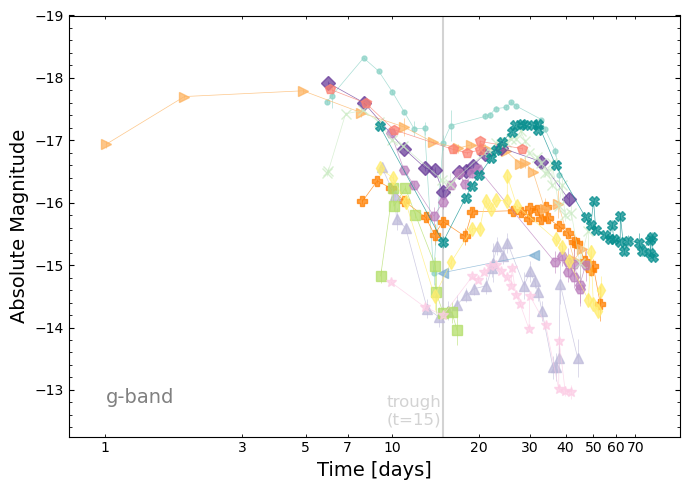

In [318]:
%matplotlib inline
markers = ['.','P','^','<','>','s','*','D','H','x','d','p','X']
plt.figure(figsize=(7,5))
ax = plt.subplot(111)
for i,df in enumerate(df_cut_list):
    sort_df = df.sort_values(by='norm_t')
    gband = ((sort_df['filter']=='ZTF_g')|(sort_df['filter']=='c'))&(sort_df['err']<=2.0)
    plt.errorbar(sort_df.loc[gband,'norm_t'], sort_df.loc[gband,'abs_mag'], sort_df.loc[gband, 'err'], 
                 color=colors[i],ls='-',marker=markers[i], markersize=7, alpha=0.75, linewidth=0.5)
    # plt.errorbar(sort_df.loc[gband,'norm_t']+10, sort_df.loc[gband,'abs_mag'], sort_df.loc[gband, 'mag_err_all'], color=colors[i],marker='.', markersize=5, alpha=0.5)

plt.annotate('g-band',xy=(0.06,0.08),xycoords='axes fraction',color='gray',fontsize=14)
plt.xscale('log')#,subs=[2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90])
plt.xlabel('Time [days]', fontsize=14)
plt.axvline(x=15,color='lightgray',zorder=0)
plt.annotate('trough\n(t=15)',xy=(0.52, 0.03), xycoords='axes fraction',color='lightgray',fontsize=12)
plt.ylabel('Absolute Magnitude', fontsize=14)

# ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
locs = np.append(np.arange(1,8,2),np.arange(10,80,10),90)
ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator(locs))
ax.xaxis.set_major_locator(mpl.ticker.NullLocator())

ax.xaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which="both", top=True, labeltop=False, bottom=True, labelbottom=True, left=True, right=True, direction="in")

plt.xlim(0.75, 100)
plt.ylim(-12.25,-19)
# plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(SAVE_DIR+'figures/abs_mag_logt_g.png', dpi=300)

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_55637/2802325875.py:28: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 90)


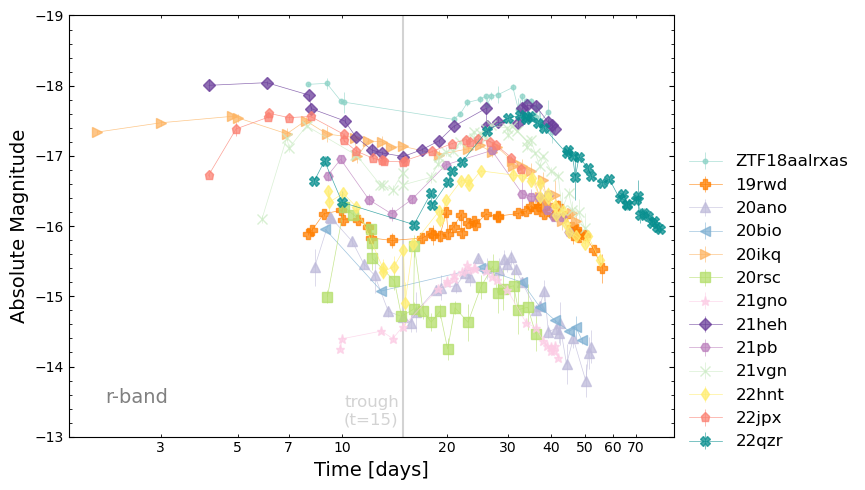

In [316]:
%matplotlib inline
# markers = ['.','H','^','<','>','s','*','D','P','x','d','p','X']
plt.figure(figsize=(8.75,5))
ax = plt.subplot(111)
for i,df in enumerate(df_cut_list):
    sort_df = df.sort_values(by='norm_t')
    rband = ((sort_df['filter']=='ZTF_r')|(sort_df['filter']=='o'))&(sort_df['err']<=2.0)
    ax.errorbar(sort_df.loc[rband,'norm_t'], sort_df.loc[rband,'abs_mag'], sort_df.loc[rband, 'err'], 
                color=colors[i], ls='-', marker=markers[i], markersize=6.5, alpha=0.75, label=plot_names[i], linewidth=0.5)
    # plt.errorbar(sort_df.loc[rband,'norm_t']+10, sort_df.loc[rband,'abs_mag'], sort_df.loc[rband, 'mag_err_all'], color=colors[i], marker='.', markersize=5, alpha=0.5)

plt.annotate('r-band',xy=(0.06,0.08),xycoords='axes fraction',color='gray',fontsize=14)
plt.xscale('log')#,subs=[2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90])
plt.xlabel('Time [days]', fontsize=14)
plt.axvline(x=15,color='lightgray',zorder=0)
plt.annotate('trough\n(t=15)',xy=(0.455, 0.03), xycoords='axes fraction',color='lightgray',fontsize=12)
plt.ylabel('Absolute Magnitude', fontsize=14)

ax.yaxis.set_minor_locator(AutoMinorLocator())
locs = np.append( np.arange(1,8,2),np.arange(10,80,10))
ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator(locs))
ax.xaxis.set_major_locator(mpl.ticker.NullLocator())

ax.xaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which="both", top=True, labeltop=False, bottom=True, labelbottom=True, left=True, right=True, direction="in")


plt.xlim(0, 90)
plt.ylim(-13,-19)
# plt.gca().invert_yaxis()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.32),frameon=False, fontsize=12)
plt.tight_layout()
plt.savefig(SAVE_DIR+'figures/abs_mag_logt_r.png', dpi=300)

In [397]:
############################
#    making t_1/2 plots
############################

In [398]:
#calculated earlier in notebook
bestfit_df[['SN_ID','t_half-g','t_half-r','a1_abs_mag-g','a1_abs_mag-r']]

,SN_ID,t_half-g,t_half-r,a1_abs_mag-g,a1_abs_mag-r
index,,,,,
0,snztf18,3.35,6.95,-18.647785,-18.044132
1,sn19rwd,6.23,6.64,-16.427769,-16.248555
2,sn20ano,NaN,3.18,NaN,-16.037139
3,sn20bio,5.22,3.79,-15.658632,-16.133632
4,sn20ikq,7.63,14.92,-18.214126,-17.573363
5,sn20rsc,2.56,3.98,-16.393273,-16.041990
6,sn21gno,4.61,3.78,-14.828574,-14.816344
7,sn21heh,5.47,7.47,-18.341264,-18.206037
8,sn21pb,NaN,5.86,NaN,-16.939797


In [399]:
# markers = ['.','P','^','<','>','s','*','D','H','x','d','p','X']
# plt.figure(figsize=(7.75,6))
# ax = plt.subplot(111)

# # t-half and abs_mag of a1 come from bestfit_df
# for i,df in enumerate(df_sub_ls):
#     plt.scatter(bestfit_df.loc[bestfit_df['SN_ID']==df_str_list[i], 't_half-r'],
#                 bestfit_df.loc[bestfit_df['SN_ID']==df_str_list[i], 'a1_abs_mag-r'],
#                 label=df_str_list[i], color=colors[i], marker=markers[i],s=75)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, loc='center left', bbox_to_anchor=(0.985, 0.32),frameon=False, fontsize=12)
# plt.xlabel('Time above half-maximum [days]', fontsize=12)
# plt.ylabel('Absolute r-band Magnitude of SCE peak')
# # plt.axvline(x=12, color='lightgray', label='12-day FBOT cut-off')
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.savefig(SAVE_DIR+'figures/abs_mag_vs_t_half.png')

In [400]:
# reading in Ho23 FBOT Table
fbots = pd.read_csv('./data/fbot_table.csv',header=0, sep='\s+')

#dropping objects w/o redshift since need to convert to abs_mag w/ z->D
fbots = fbots.dropna(axis=0, ignore_index=True, subset='z')

#adding in classic FBOTs not already included
fbots.loc[len(df.index)] = [np.nan, np.nan, np.nan,np.nan,np.nan,np.nan,np.nan,'AT2018cow',np.nan, np.nan, 0.05,1.1+1.96, 0.04+0.12,np.nan,0.0141,'IIn/Ibn'] 

#converting z to distance w/ astropy
z = fbots.z.values * cu.redshift
fbots['d_calc'] = np.array(z.to(u.Mpc, cu.redshift_distance(WMAP9, kind="comoving")))

#calculate absolute mag from distance and app_mag (Pmag) which is g-band here
fbots['abs_mag_g'] = fbots['Pmag'] - 2.5*np.log10(((fbots['d_calc']*1e6)/10)**2)
fbots['Ho23_abs_mag'] = fbots['Pmag'] - 5*np.log10((fbots['d_calc']*1e6)/10) + 2.5*np.log10(1+fbots['z'])
# (fbots['abs_mag_g']-fbots['Ho23_abs_mag']).describe() #see the difference b/w my conversion equation and the one used in Ho23

fbots.loc[fbots['IAU']=='AT2018cow','Ho23_abs_mag'] = -20.87
fbots.loc[fbots['IAU']=='AT2018cow','abs_mag_g'] = -20.87 #tacking onto my calc'd absmag_g column for plotting sakes
fbots

,ZTF,RAh,RAm,RAs,DE-,DEd,DEs,IAU,MJD,Pmag,e_Pmag,t0.5_g,e_t0.5_g,g-r,z,Class,d_calc,abs_mag_g,Ho23_abs_mag
0,18aakuewf,16.0,14.0,22.65,35.0,55.0,4.4,SN2018bcc,58230.38,17.46,0.04,9.10,0.40,-0.3,0.06360,Ibn,271.241505,-19.706781,-19.639835
1,18abfcmjw,17.0,36.0,46.74,50.0,32.0,52.1,SN2019dge,58583.16,18.40,0.02,6.10,0.20,-0.2,0.02130,Ib,91.693559,-16.411694,-16.388811
2,18abukavn,16.0,43.0,48.20,41.0,2.0,43.3,SN2018gep,58374.22,15.91,0.01,9.30,0.20,-0.4,0.03154,Ic-BL,135.471494,-19.749240,-19.715524
3,18abvkmgw,0.0,37.0,26.87,15.0,0.0,51.2,SN2018ghd,58377.35,18.49,0.03,9.50,0.90,-0.1,0.03923,Ib,168.216900,-17.639348,-17.597569
4,18abvkwla,2.0,0.0,15.19,16.0,47.0,57.3,AT2018lug,58374.41,19.34,0.05,4.00,0.10,-0.6,0.27140,Feat.;RL,1102.094673,-20.871095,-20.610389
5,18abwkrbl,2.0,16.0,15.58,28.0,35.0,28.6,SN2018gjx,58379.44,15.58,0.01,7.40,0.10,-0.2,0.00999,IIb,43.111369,-17.592959,-17.582166
6,19aapfmki,14.0,5.0,43.56,9.0,30.0,56.6,SN2019deh,58587.33,17.22,0.02,10.70,0.70,-0.2,0.05469,Ibn,233.706630,-19.623355,-19.565543
7,19aatoboa,12.0,25.0,40.57,44.0,44.0,48.8,AT2019esf,58609.22,18.84,0.03,7.20,0.60,-0.4,0.07580,NaN,322.387120,-18.701888,-18.622560
8,19abfarpa,11.0,7.0,9.56,57.0,6.0,3.2,AT2019kyw,58676.18,18.28,0.04,11.90,0.50,-0.2,0.07400,NaN,314.859197,-19.210582,-19.133071
9,19abobxik,0.0,43.0,43.12,37.0,3.0,38.9,SN2019myn,58706.45,18.84,0.02,9.50,0.80,-0.1,0.10000,Ibn,422.982356,-19.291611,-19.188130


/Users/pnr5sh/miniconda3/envs/astro/lib/python3.11/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


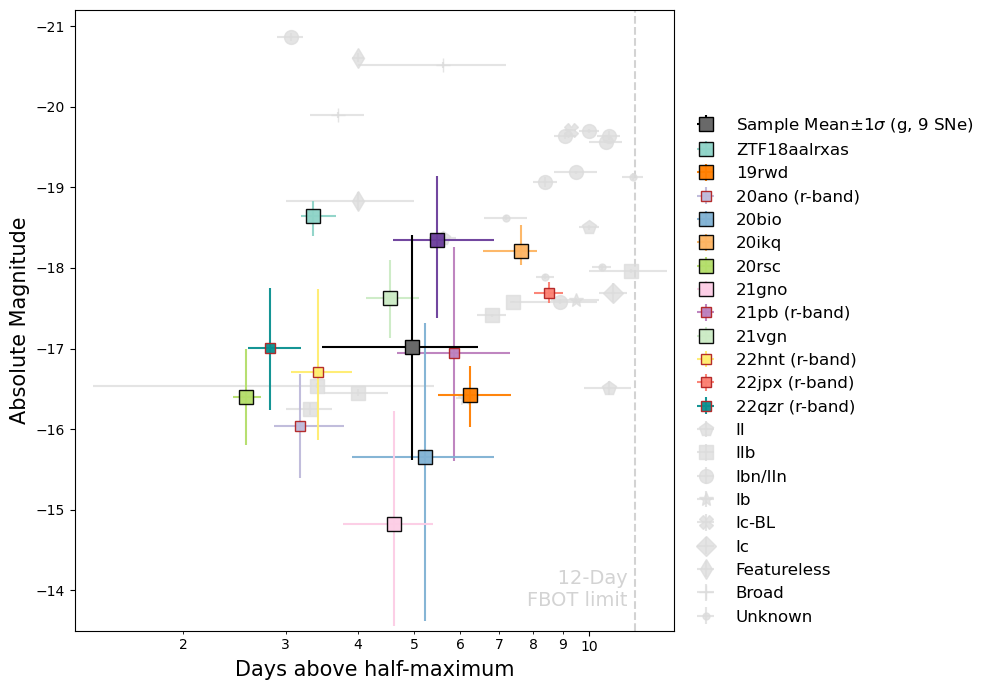

In [406]:
from matplotlib.ticker import FormatStrFormatter
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(111)

ii = (fbots['Class']=='II')|(fbots['Class']=='II?')
iib = (fbots['Class']=='IIb')
iinb = (fbots['Class']=='Ibn')|(fbots['Class']=='IIn')|(fbots['Class']=='IIn?')|(fbots['Class']=='IIn/Ibn')
ib = (fbots['Class']=='Ib')
icbl = (fbots['Class']=='Ic-BL')
ic = (fbots['Class']=='Ic')
fless = (fbots['Class']=='Feat.;RL')|(fbots['Class']=='Feat.')
broad = (fbots['Class']=='UB')|(fbots['Class']=='UB;RL')
unknow = (fbots['Class'].isna())

types = [ii,iib,iinb,ib,icbl,ic,fless,broad,unknow]
markers = ['p','s','o','*','X','D','d','+', '.']
labels = ['II','IIb','Ibn/IIn','Ib','Ic-BL','Ic','Featureless','Broad','Unknown']

has_g = (bestfit_df['t_half-g'].notna())
no_g = ~has_g

#plotting mean t_1/2 and mean abs_mag
#gband
plt.errorbar(stats_df.loc[stats_df['param']=='t_half-g', 'mean'],
             bestfit_df.loc[has_g, 'a1_abs_mag-g'].mean(),
             xerr=stats_df.loc[stats_df['param']=='t_half-g', 'std'],
             yerr=bestfit_df.loc[has_g, 'a1_abs_mag-g'].std(),
             label='Sample Mean$\pm 1 \sigma$ (g, 9 SNe)',
             marker='s', ls='', ecolor='black', markerfacecolor='dimgray', markeredgecolor='black', markersize=10,zorder=50)
# #rband
# plt.errorbar(stats_df.loc[stats_df['param']=='t_half-r', 'mean'],
#              stats_df.loc[stats_df['param']=='a1_abs_mag-r', 'mean'],
#              xerr=stats_df.loc[stats_df['param']=='t_half-r', 'std'],
#              yerr=stats_df.loc[stats_df['param']=='a1_abs_mag-r', 'std'],
#              label='Sample Mean (r-band) $\pm 1 \sigma$',
#              marker='s', ls='', ecolor='black', markerfacecolor='dimgray', markeredgecolor='firebrick', markersize=10,zorder=50)
    
#plotting my data
#plotting for objects w/ g-band m1/a1
xerr_low_g = bestfit_df['t_half-g'] - bestfit_df['t_half_16-g']
xerr_high_g = bestfit_df['t_half_84-g'] - bestfit_df['t_half-g']
xerr_low_r = bestfit_df['t_half-r'] - bestfit_df['t_half_16-r']
xerr_high_r = bestfit_df['t_half_84-r'] - bestfit_df['t_half-r']

for i,df in enumerate(df_sub_ls):
    # print('ON SN:', df_str_list[i])
    plt.errorbar(bestfit_df.loc[(has_g)&(bestfit_df['SN_ID']==df_str_list[i]), 't_half-g'],
                bestfit_df.loc[(has_g)&(bestfit_df['SN_ID']==df_str_list[i]), 'a1_abs_mag-g'],
                xerr=[xerr_low_g.loc[(has_g)&(bestfit_df['SN_ID']==df_str_list[i])],xerr_high_g.loc[(has_g)&(bestfit_df['SN_ID']==df_str_list[i])]],
                yerr=[bestfit_df.loc[(has_g)&(bestfit_df['SN_ID']==df_str_list[i]), '-e_a1_abs_mag-g'],bestfit_df.loc[(has_g)&(bestfit_df['SN_ID']==df_str_list[i]), '+e_a1_abs_mag-g']],
                xuplims=False,ls='',label=plot_names[i], markerfacecolor=colors[i],markeredgecolor='black', ecolor=colors[i], marker='s',markersize=10, alpha=0.95,zorder=10)
    plt.errorbar(bestfit_df.loc[(no_g)&(bestfit_df['SN_ID']==df_str_list[i]), 't_half-r'],
                bestfit_df.loc[(no_g)&(bestfit_df['SN_ID']==df_str_list[i]), 'a1_abs_mag-r'],
                xerr=[xerr_low_r.loc[(no_g)&(bestfit_df['SN_ID']==df_str_list[i])],xerr_high_r.loc[(no_g)&(bestfit_df['SN_ID']==df_str_list[i])]],
                yerr=[bestfit_df.loc[(no_g)&(bestfit_df['SN_ID']==df_str_list[i]), '-e_a1_abs_mag-r'],bestfit_df.loc[(no_g)&(bestfit_df['SN_ID']==df_str_list[i]), '+e_a1_abs_mag-r']],
                xuplims=False,ls='',label=plot_names[i]+' (r-band)', markerfacecolor=colors[i],markeredgecolor='firebrick', ecolor=colors[i],marker='s',markersize=7, alpha=0.95,zorder=5)
    
#plotting anna's
for i in range(len(types)):
    plt.errorbar(fbots.loc[types[i],'t0.5_g'], fbots.loc[types[i],'Ho23_abs_mag'], yerr=fbots.loc[types[i],'e_Pmag'], xerr=fbots.loc[types[i],'e_t0.5_g'],
                 ls='', marker=markers[i], markersize='10', label=labels[i], alpha=0.75, color='gainsboro')
# plt.scatter(fbots.loc[fbots['IAU']=='SN2020ano', 't0.5_g'], fbots.loc[fbots['IAU']=='SN2020ano', 'Ho23_abs_mag'], marker='s', color='cyan',s=60)
# plt.scatter(fbots.loc[fbots['IAU']=='SN2020ikq', 't0.5_g'], fbots.loc[fbots['IAU']=='SN2020ikq', 'Ho23_abs_mag'], marker='*', color='cyan',s=60)
# plt.scatter(fbots.loc[fbots['IAU']=='SN2020rsc', 't0.5_g'], fbots.loc[fbots['IAU']=='SN2020rsc', 'Ho23_abs_mag'], marker='v', color='cyan',s=60)

plt.gca().invert_yaxis()
plt.axvline(x=12,color='lightgray',ls='dashed')
plt.xscale('log')
ax.xaxis.set_minor_formatter(FormatStrFormatter("%.i"))
ax.xaxis.set_major_formatter(FormatStrFormatter("%.i"))
plt.annotate('     12-Day\nFBOT limit',xy=(0.755,0.04),xycoords='axes fraction',color='lightgray',fontsize=14)

# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, loc='center left', bbox_to_anchor=(0.985, 0.5),frameon=False, fontsize=12)

handles, labels = ax.get_legend_handles_labels()
h1, l1 = handles[0:1], labels[0:1]
h2, l2 = handles[1:4:2], labels[1:4:2]
h25, l25 = handles[6:7], labels[6:7]
h3, l3 = handles[7:15:2], labels[7:15:2]
h35, l35 = handles[18:20], labels[18:20]
h4, l4 = handles[22:27:2], labels[22:27:2]
h5, l5 = handles[27:], labels[27:]

h = h1+h2+h25+h3+h35+h4+h5
l = l1+l2+l25+l3+l35+l4+l5
ax.legend(h, l, loc='center left', bbox_to_anchor=(1, 0.42),frameon=False, fontsize=12)

plt.xlim(1.3,14)
plt.ylim(-13.5,-21.2)

plt.xlabel('Days above half-maximum', fontsize=15)
plt.ylabel('Absolute Magnitude', fontsize=15)
plt.tight_layout()
plt.savefig(SAVE_DIR+'figures/abs_mag_t_half_Ho23_overlay.png', dpi=300)

In [322]:
stats_df.loc[stats_df['param']=='t_half-g', 'mean'].iloc[0],stats_df.loc[stats_df['param']=='t_half-g', 'std'].iloc[0],bestfit_df.loc[has_g, 'a1_abs_mag-g'].mean(),bestfit_df.loc[has_g, 'a1_abs_mag-g'].std()

(4.9499999999998945,
 1.4886319222695399,
 -17.016779264950344,
 1.3930363603090286)

vvv testing stuff vvv

In [1204]:
fbots.loc[(fbots['IAU']=='SN2020ano')|(fbots['IAU']=='SN2020ikq')|(fbots['IAU']=='SN2020rsc'),['IAU','t0.5_g','e_t0.5_g','Ho23_abs_mag']]

,IAU,t0.5_g,e_t0.5_g,Ho23_abs_mag
15,SN2020ano,3.4,2.0,-16.537739
18,SN2020ikq,11.8,1.8,-17.961506
24,SN2020rsc,3.3,0.3,-16.249305


In [1205]:
bestfit_df.loc[(bestfit_df['SN_ID']=='sn20ano')|(bestfit_df['SN_ID']=='sn20ikq')|(bestfit_df['SN_ID']=='sn20rsc'), ['SN_ID','t_half-g','a1_abs_mag-g']]

,SN_ID,t_half-g,a1_abs_mag-g
2,sn20ano,3.21,-16.210740
4,sn20ikq,7.65,-18.214126
5,sn20rsc,2.55,-16.393273


In [1065]:
# #calculate t_1/2 from individual mcmc fits,

# def calc_t_half(df_sub, df_str, color='black'):
#     df_sub = df_sub.sort_values(by='norm_t')
#     gridspec = dict(hspace=0.0)
#     fig, ax = plt.subplots(2,1, figsize=(6,8),sharex=True,gridspec_kw=gridspec)
#     ###gband
#     gband = (df_sub['filter']=='ZTF_g') | (df_sub['filter']=='c')
    
#     best_df = bestfit_df.loc[bestfit_df['SN_ID']==df_str]
#     x_list = pd.Series(np.arange(0,25,0.01))

#     #generating mags from bestfit model
#     if r1_bool_dict['g'][df_str]:
#         print(df_str, 'has m1')
#         #find time of max
#         ta1 = best_df.a1_g.iloc[0]                    #time of a1, SCE peak
#         ta2 = best_df.a2_g.iloc[0]                    #time of a2, trough
#         x_list_ba1 = x_list.loc[x_list<=ta1]          #slicing times before a1
#         x_list_aa1 = x_list.loc[(ta1<=x_list)&(x_list<=ta2)]          #slicing times after a1 and before a2
#         best = best_df[['m1_g','m2_g','m3_g','b2_g','a1_g','a2_g','log_f_g']].iloc[0].to_numpy()
#     else:
#         print(df_str, 'has NO m1')
#         #find time of max
#         ta1 = df_sub.norm_t.min()                     #time of a1, first obs
#         ta2 = best_df.a2_g.iloc[0]                    #time of a2, trough
#         x_list_ba1 = x_list.loc[x_list<=ta1]          #slicing times before a1
#         x_list_aa1 = x_list.loc[(ta1<=x_list)&(x_list<=ta2)]          #slicing times after a1
#         best = best_df[['m2_g','m3_g','b2_g','a2_g','log_f_g']].iloc[0].to_numpy()
#     print(ta1, ta2)
#     # print(x_list_ba1, x_list_aa1)
#     m_a1 = model(best, ta1, r1=r1_bool_dict['g'][df_str]) #maximum magnitude
#     m_half = -2.5*np.log10(0.5)+m_a1                      #half maximum magnitude (flux-scaling)

#     #find mags before and after a1 that equal m_half
#     g_mags_ba1 = pd.Series([model(best, x, r1=r1_bool_dict['g'][df_str]) for x in x_list_ba1])
#     g_mags_aa1 = pd.Series([model(best, x, r1=r1_bool_dict['g'][df_str]) for x in x_list_aa1])
#     m_half_ba1 = g_mags_ba1.index[(g_mags_ba1-m_half).abs().argsort()[0]]
#     m_half_aa1 = g_mags_aa1.index[(g_mags_aa1-m_half).abs().argsort()[0]]

#     #find t's at those mag indeces
#     if r1_bool_dict['g'][df_str]:
#         t_half_ba1 = x_list_ba1.iloc[m_half_ba1]
#         t_half_aa1 = x_list_aa1.iloc[m_half_aa1]
#         t_half = t_half_aa1 - t_half_ba1
#     else:
#         # could use time above half max after a1 as a lower bound for those w/o full g-band SCE
#         # t_half_aa1 = x_list_aa1.iloc[m_half_aa1]
#         # t_half = t_half_aa1

#         #for now just saying t_half = np.nan and plotting r-band later
#         t_half_ba1,t_half_aa1 = np.nan, np.nan
#         t_half = np.nan
#     bestfit_df.loc[bestfit_df['SN_ID']==df_str, 't_half-g'] = t_half

#     # calc abs mag of SCE peak (a1)
#     a1_index = np.abs(x_list - ta1).argmin()
#     app_mag_a1 = (np.array([model(best, v, r1=r1_bool_dict['g'][df_str]) for v in x_list])[a1_index] + 
#                   mag_conversion_df.loc[mag_conversion_df['sn']==df_str].norm_mag_shift.iloc[0])
#     abs_mag_a1 = (app_mag_a1 - mag_conversion_df.loc[mag_conversion_df['sn']==df_str].mag_conversion.iloc[0] - 
#                   mag_conversion_df.loc[mag_conversion_df['sn']==df_str].ext_g.iloc[0])
#     bestfit_df.loc[bestfit_df['SN_ID']==df_str, 'a1_abs_mag-g'] = abs_mag_a1

#     ax[0].plot(x_list, np.array([model(best, v, r1=r1_bool_dict['g'][df_str]) for v in x_list]), c=color)
#     ax[0].axhline(m_half)
#     ax[0].axvspan(t_half_ba1,t_half_aa1,color='lightgray',alpha=0.5)
#     ax[0].invert_yaxis()
#     bbox = dict(facecolor='white', edgecolor='white',alpha=0.85)
#     ax[0].annotate('g-band',xy=(0.5,0.12),xycoords='axes fraction',color='gray',fontsize=14,bbox=bbox)
#     ax[0].annotate('t_half='+str(round(t_half,3))+' days',xy=(0.5,0.04),xycoords='axes fraction',color='gray',fontsize=14,bbox=bbox)
#     ax[0].xaxis.set_minor_locator(AutoMinorLocator())
#     ax[0].yaxis.set_minor_locator(AutoMinorLocator())
#     ax[0].tick_params(which="both",top=True, labeltop=False, bottom=True, labelbottom=False, left=True, right=True, direction="in",zorder=0)

# ###########################################
#     ###rband
#     rband = (df_sub['filter']=='ZTF_r') | (df_sub['filter']=='o')
    
#     best_df = bestfit_df.loc[bestfit_df['SN_ID']==df_str]
#     x_list = pd.Series(np.arange(0,25,0.01))

#     #generating mags from bestfit model
#     if r1_bool_dict['r'][df_str]:
#         print(df_str, 'has m1')
#         #find time of max
#         ta1 = best_df.a1_r.iloc[0]                    #time of a1, SCE peak
#         ta2 = best_df.a2_r.iloc[0]                    #time of a2, trough
#         x_list_ba1 = x_list.loc[x_list<=ta1]          #slicing times before a1
#         x_list_aa1 = x_list.loc[(ta1<=x_list)&(x_list<=ta2)]          #slicing times after a1 and before a2
#         best = best_df[['m1_r','m2_r','m3_r','b2_r','a1_r','a2_r','log_f_r']].iloc[0].to_numpy()
#     else:
#         print(df_str, 'has NO m1')
#         #find time of max
#         ta1 = df_sub.norm_t.min()                     #time of a1, first obs
#         ta2 = best_df.a2_r.iloc[0]                    #time of a2, trough
#         x_list_ba1 = x_list.loc[x_list<=ta1]          #slicing times before a1
#         x_list_aa1 = x_list.loc[(ta1<=x_list)&(x_list<=ta2)]          #slicing times after a1
#         best = best_df[['m2_r','m3_r','b2_r','a2_r','log_f_r']].iloc[0].to_numpy()
#     print(ta1, ta2)
#     # print(x_list_ba1, x_list_aa1)
#     m_a1 = model(best, ta1, r1=r1_bool_dict['r'][df_str]) #maximum magnitude
#     m_half = -2.5*np.log10(0.5)+m_a1                      #half maximum magnitude (flux-scaling)

#     #find mags before and after a1 that equal m_half
#     r_mags_ba1 = pd.Series([model(best, x, r1=r1_bool_dict['r'][df_str]) for x in x_list_ba1])
#     r_mags_aa1 = pd.Series([model(best, x, r1=r1_bool_dict['r'][df_str]) for x in x_list_aa1])
#     m_half_ba1 = r_mags_ba1.index[(r_mags_ba1-m_half).abs().argsort()[0]]
#     m_half_aa1 = r_mags_aa1.index[(r_mags_aa1-m_half).abs().argsort()[0]]

#     #find t's at those mag indeces
#     if r1_bool_dict['r'][df_str]:
#         t_half_ba1 = x_list_ba1.iloc[m_half_ba1]
#         t_half_aa1 = x_list_aa1.iloc[m_half_aa1]
#         t_half = t_half_aa1 - t_half_ba1
#     else:
#         # could use time above half max after a1 as a lower bound for those w/o full g-band SCE
#         # t_half_aa1 = x_list_aa1.iloc[m_half_aa1]
#         # t_half = t_half_aa1

#         #for now just saying t_half = np.nan and plotting r-band later
#         t_half_ba1,t_half_aa1 = np.nan, np.nan
#         t_half = np.nan
#     bestfit_df.loc[bestfit_df['SN_ID']==df_str, 't_half-r'] = t_half

#     # calc abs mag of SCE peak (a1)
#     a1_index = np.abs(x_list - ta1).argmin()
#     app_mag_a1 = (np.array([model(best, v, r1=r1_bool_dict['r'][df_str]) for v in x_list])[a1_index] + 
#                   mag_conversion_df.loc[mag_conversion_df['sn']==df_str].norm_mag_shift.iloc[0])
#     abs_mag_a1 = (app_mag_a1 - mag_conversion_df.loc[mag_conversion_df['sn']==df_str].mag_conversion.iloc[0] - 
#                   mag_conversion_df.loc[mag_conversion_df['sn']==df_str].ext_r.iloc[0])
#     bestfit_df.loc[bestfit_df['SN_ID']==df_str, 'a1_abs_mag-r'] = abs_mag_a1

#     ax[1].plot(x_list, np.array([model(best, v, r1=r1_bool_dict['r'][df_str]) for v in x_list]), c=color)
#     ax[1].axhline(m_half)
#     ax[1].axvspan(t_half_ba1,t_half_aa1,color='lightgray',alpha=0.5)
#     ax[1].invert_yaxis()
#     bbox = dict(facecolor='white', edgecolor='white',alpha=0.85)
#     ax[1].annotate('r-band',xy=(0.5,0.12),xycoords='axes fraction',color='gray',fontsize=14,bbox=bbox)
#     ax[1].annotate('t_half='+str(round(t_half,3))+' days',xy=(0.5,0.04),xycoords='axes fraction',color='gray',fontsize=14,bbox=bbox)
#     ax[1].xaxis.set_minor_locator(AutoMinorLocator())
#     ax[1].yaxis.set_minor_locator(AutoMinorLocator())
#     ax[1].tick_params(which="both",top=True, labeltop=False, bottom=True, labelbottom=False, left=True, right=True, direction="in",zorder=0)

#     #plotting to compare/check

#     plt.xlabel('Time [days]')
#     plt.ylabel('Normalized Mag')
#     plt.suptitle(df_str+'\n(g-r) t_half = '+str(round((bestfit_df.loc[bestfit_df['SN_ID']==df_str, 't_half-g']-bestfit_df.loc[bestfit_df['SN_ID']==df_str, 't_half-r']).iloc[0],3)))
#     plt.tight_layout()

#     return

snztf18 has m1
6.714141013928119 13.107969052000968
snztf18 has m1
7.66304076502529 15.613059512325332
sn19rwd has m1
8.261811821051513 14.163971583056943
sn19rwd has m1
8.728791646478744 13.82015292957411
sn20ano has m1
9.180604768067962 14.371974781632872
sn20ano has m1
8.72293772009122 13.916713624292878
sn20bio has m1
9.410124652588069 14.71730867893379
sn20bio has m1
9.193013756837964 16.188674827898204
sn20ikq has m1
2.2417309009843183 14.64140521348218
sn20ikq has m1
1.5826487470807322 15.622304574547037
sn20rsc has m1
10.071302300202417 17.606732710117512
sn20rsc has m1
10.101721880011304 16.25439992729655
sn21gno has m1
9.798066566794084 13.929084398971039
sn21gno has m1
10.381561962697235 13.48105058097142
sn21heh has m1
2.6940319952994747 14.985388173314332
sn21heh has m1
4.501013921101166 13.92208120063755
sn21pb has NO m1
7.026162000373006 13.760905533822513
sn21pb has m1
8.766433576987886 14.15698580085224
sn21vgn has m1
7.23651461621449 13.5272170081792
sn21vgn has m1
7.

,SN_ID,t_half-g,t_half-r,t_half_(g-r)
0,snztf18,3.32,6.96,-3.64
1,sn19rwd,6.07,6.55,-0.48
2,sn20ano,3.21,3.57,-0.36
3,sn20bio,5.13,3.59,1.54
4,sn20ikq,7.65,14.82,-7.17
5,sn20rsc,2.55,3.88,-1.33
6,sn21gno,4.60,3.77,0.83
7,sn21heh,5.30,7.21,-1.91
8,sn21pb,NaN,5.91,NaN
9,sn21vgn,4.53,5.00,-0.47


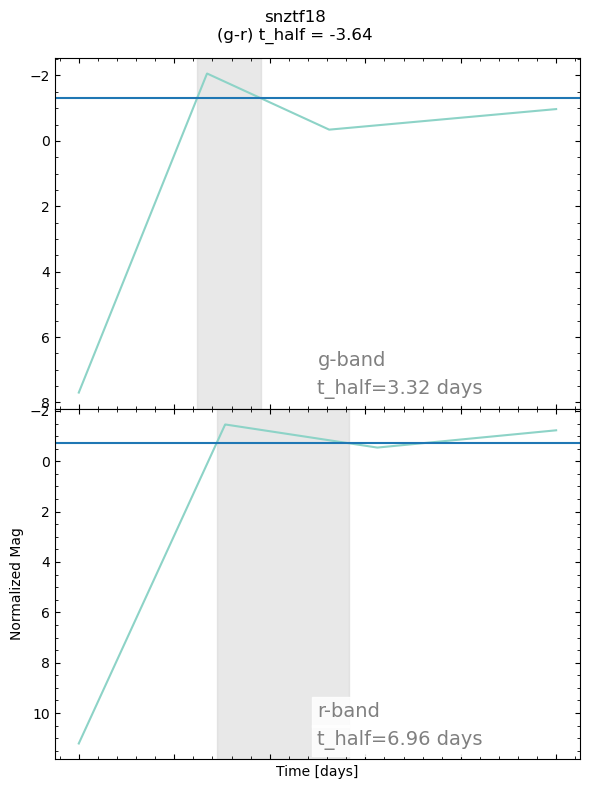

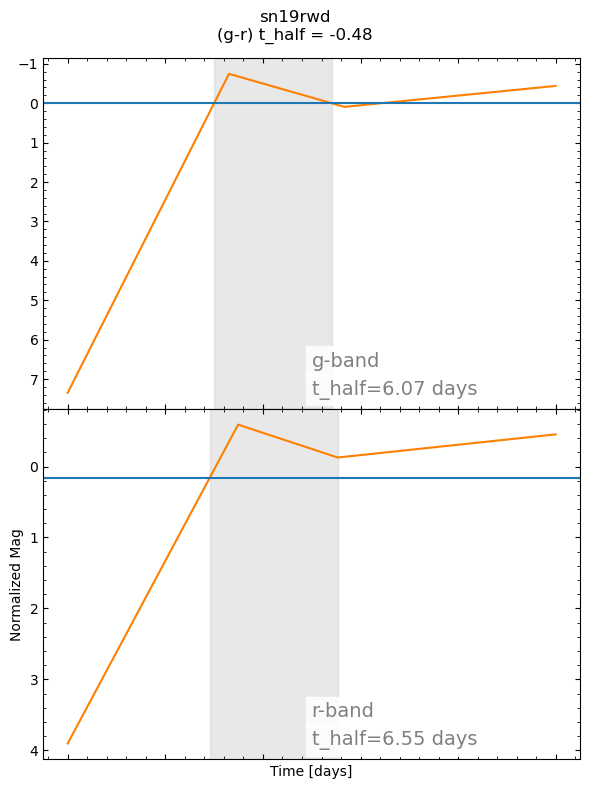

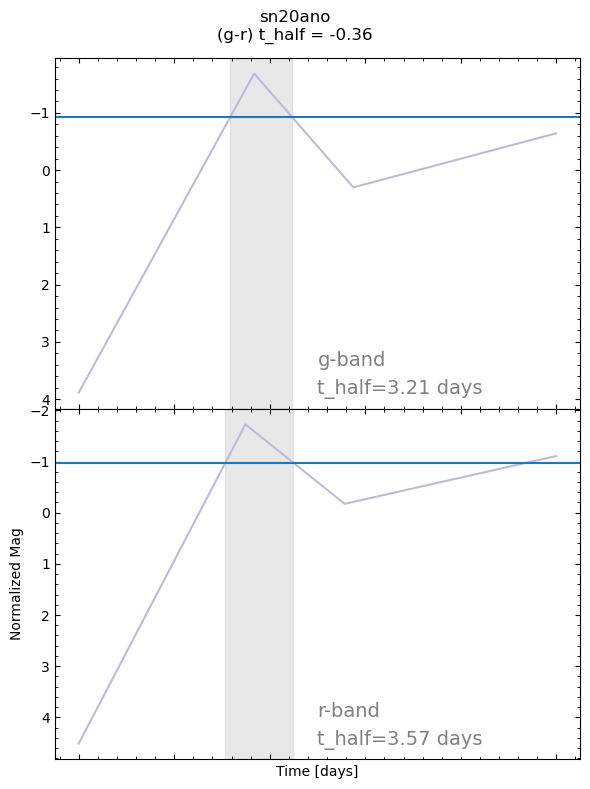

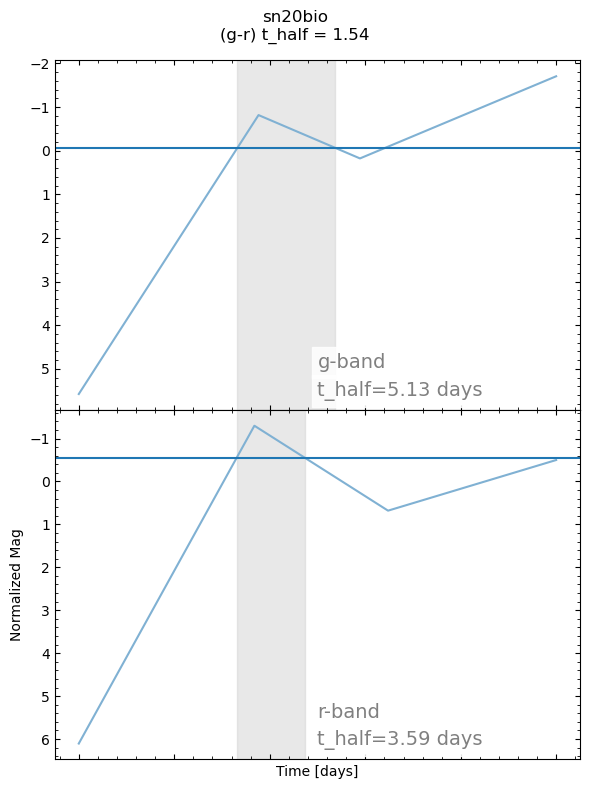

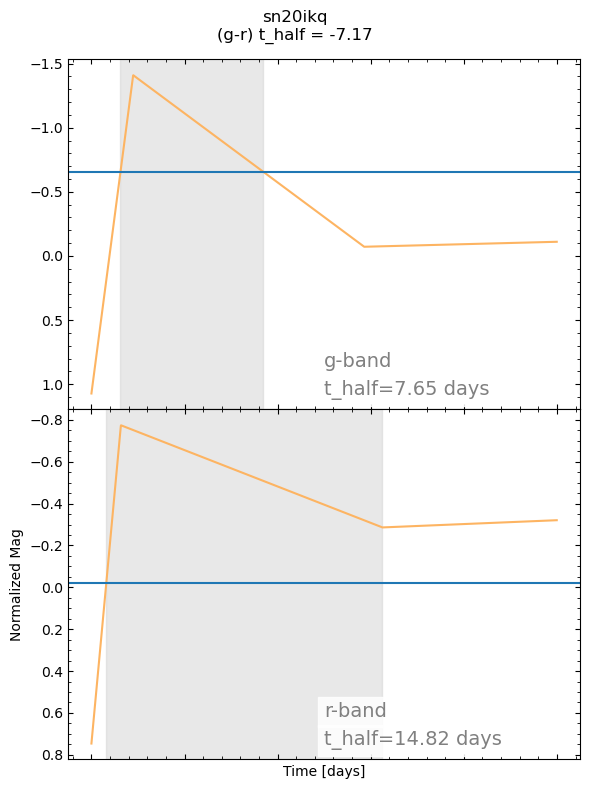

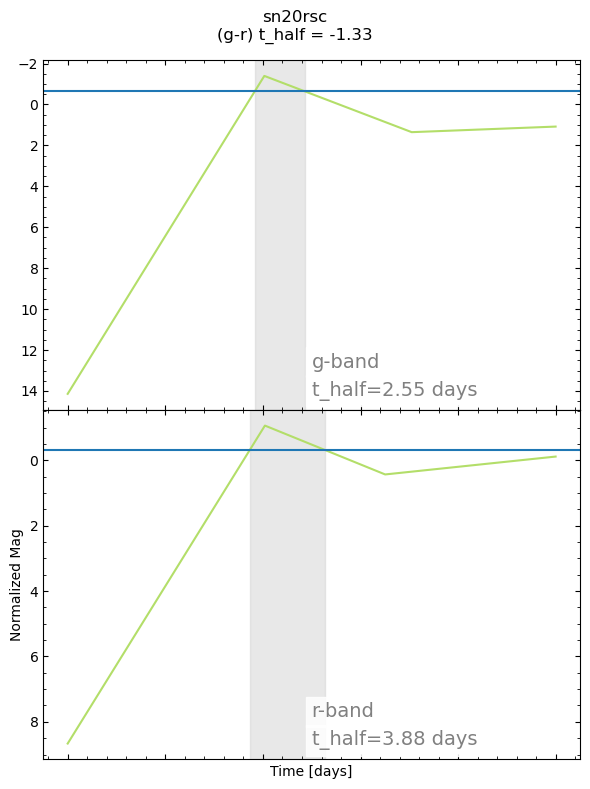

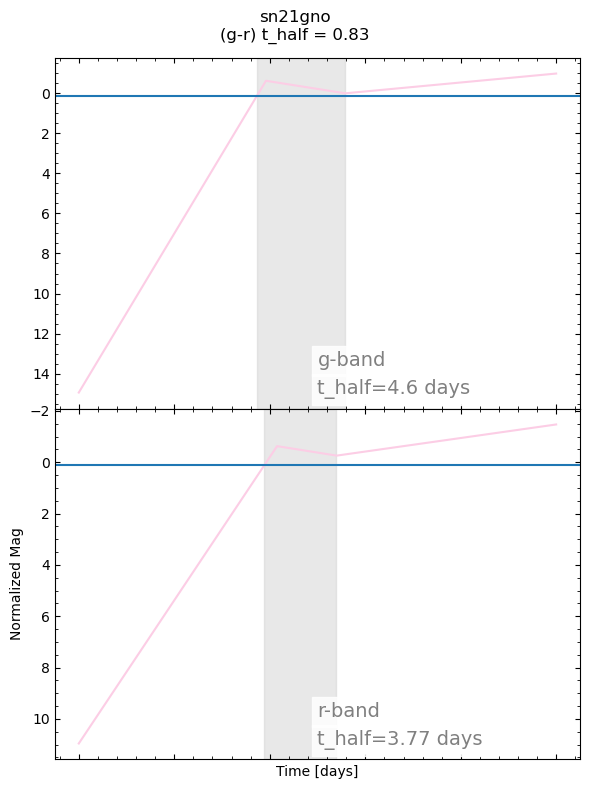

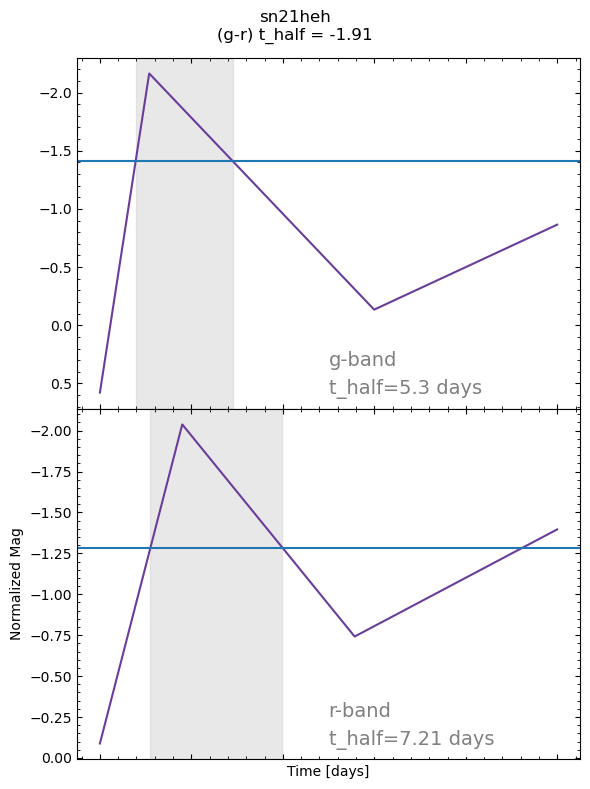

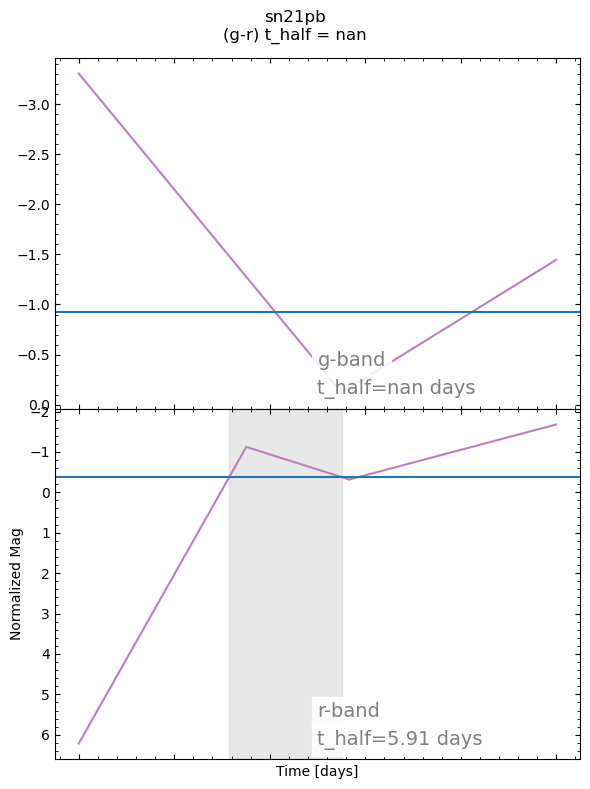

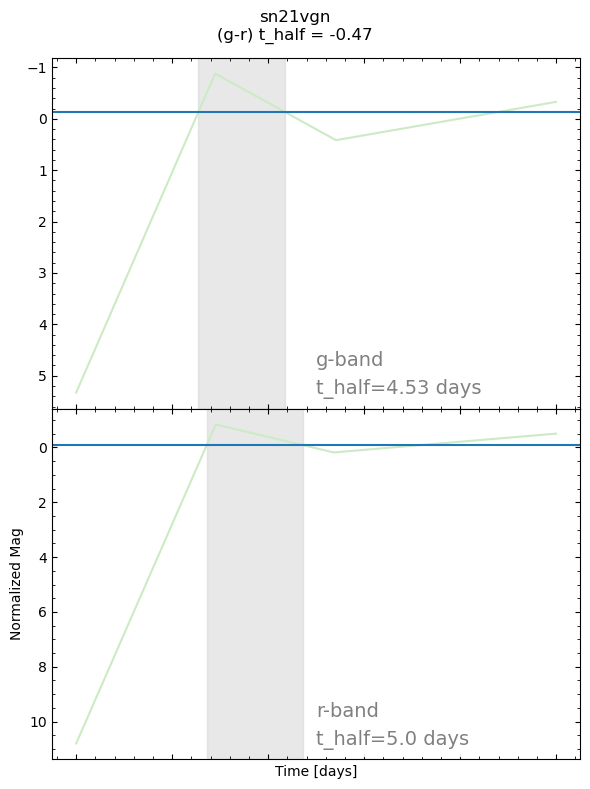

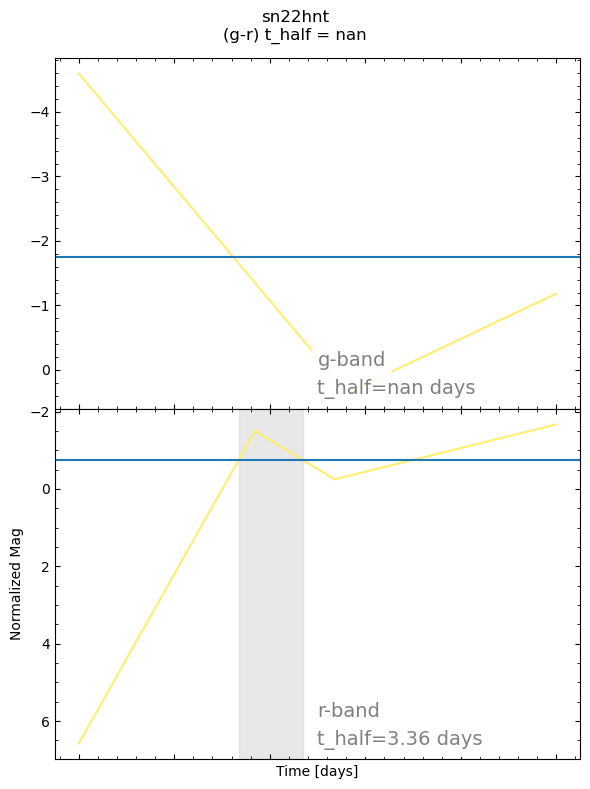

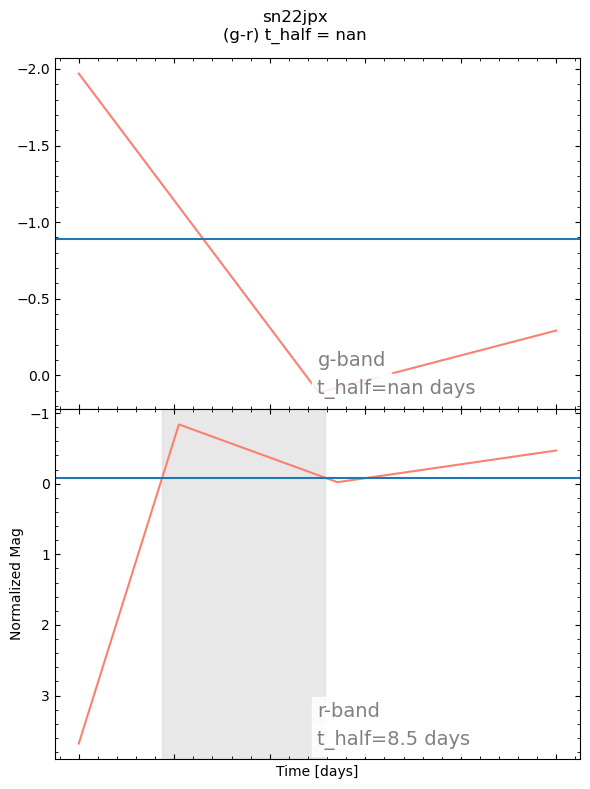

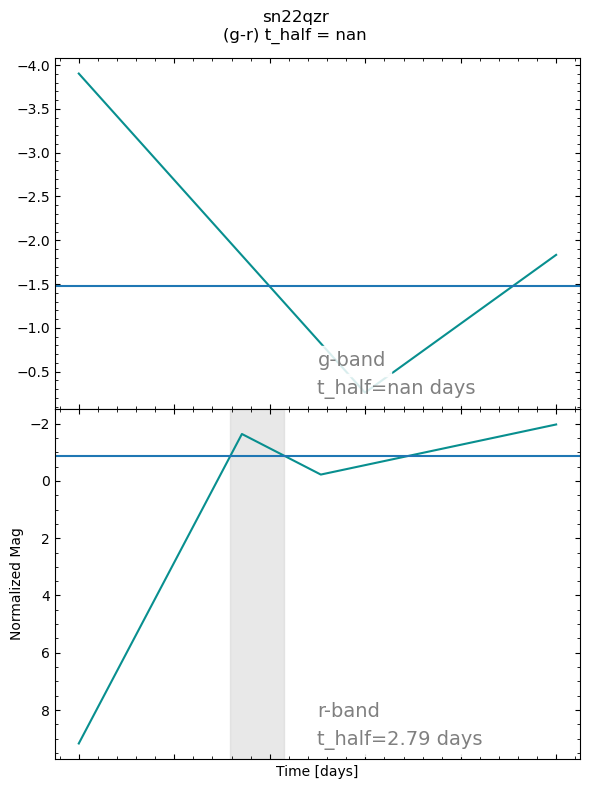

In [1089]:
for i,df in enumerate(df_sub_ls):
    calc_t_half(df, df_str_list[i],color=colors[i])
bestfit_df['t_half_(g-r)'] = bestfit_df['t_half-g'] - bestfit_df['t_half-r']
bestfit_df[['SN_ID', 't_half-g','t_half-r','t_half_(g-r)']]